In [19]:
"""
An example of how to use bilby to perform parameter estimation for
non-gravitational wave data. In this case, fitting a linear function to
data with background Gaussian noise with unknown variance.

"""
import sys
sys.path.append('/mnt/pfs/akash.mishra/ppe_model/')
import bilby
import matplotlib.pyplot as plt
import numpy as np

In [20]:

# A few simple setup steps
label = "linear_regression"
outdir = "outdir"
bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)


# First, we define our "signal model", in this case a simple linear function
def model(time, m, c):
    return time * m + c


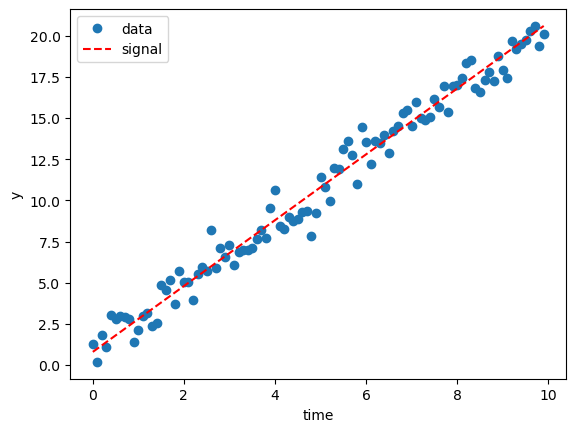

In [21]:
# Now we define the injection parameters which we make simulated data with
injection_parameters = dict(m=2, c=0.8)

# For this example, we'll inject standard Gaussian noise
sigma = 1

# These lines of code generate the fake data. Note the ** just unpacks the
# contents of the injection_parameters when calling the model function.
sampling_frequency = 10
time_duration = 10
time = np.arange(0, time_duration, 1 / sampling_frequency)
N = len(time)
data = model(time, **injection_parameters) + np.random.normal(0, sigma, N)

# We quickly plot the data to check it looks sensible
fig, ax = plt.subplots()
ax.plot(time, data, "o", label="data")
ax.plot(time, model(time, **injection_parameters), "--r", label="signal")
ax.set_xlabel("time")
ax.set_ylabel("y")
ax.legend()
fig.savefig("{}/{}_data.png".format(outdir, label))

injection_parameters.update(dict(sigma=1))

In [7]:
from prior import DiscreteUniform
likelihood = bilby.core.likelihood.GaussianLikelihood(time, data, model)


# class ConditionalCPrior(bilby.core.prior.Prior):
#     def __init__(self, m_prior, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.m_prior = m_prior

#     def rescale(self, val):
#         m = float(self.m_prior.sample())
#         if m == 0.0:
#             return bilby.core.prior.Uniform(-1, 1).rescale(val)
#         elif m == 1.0:
#             return bilby.core.prior.Uniform(3, 4).rescale(val)
#         else:
#             raise ValueError("Invalid value for 'm'")


# priors = dict()
# priors["m"] = DiscreteUniform(-1, 3, name="m")
# priors["c"] = ConditionalCPrior(priors["m"], name="c")
# priors["sigma"] = bilby.core.prior.Uniform(0, 10, name="sigma")

In [8]:
priors = dict()
def condition_func_c(m):
    """ Condition function for our p(y|x) prior."""
#   print('b',b)
    if m == 0.0:
        limit = 1
    else:
        limit = 10
        
    return dict(minimum=-limit, maximum=limit)
priors["m"] = DiscreteUniform(0, 1, name="m")
priors['c'] = bilby.core.prior.ConditionalUniform(condition_func=condition_func_c, minimum = condition_func_c(priors["m"].sample())['minimum'], maximum = condition_func_c(priors["m"].sample())['maximum'], latex_label='$\\c$')

priors["sigma"] = bilby.core.prior.Uniform(0, 5, name="sigma")

In [13]:
condition_func_c(priors["m"].sample())['minimum']

-10

In [14]:
priors["m"].sample()

1.0

In [15]:
# priors["c"].sample()
def f(p1, p2):
    m = []
    c = []
    for i in range(100):
        m.append(p1.sample())
        c.append(p2.sample())
    return m, c

In [16]:
list_m, list_c = f(priors["m"], priors["c"])

In [17]:
list(zip(list_m, list_c))

[(0.0, 4.291451512824548),
 (1.0, 5.35671922907191),
 (0.0, -0.2111402589393485),
 (0.0, -2.9871653178412867),
 (0.0, 0.7438503821997315),
 (0.0, 2.177915963796641),
 (0.0, 5.532728156576516),
 (1.0, 4.759761261408846),
 (1.0, 9.826659081271266),
 (0.0, 7.562714604907214),
 (0.0, -5.250730284299627),
 (1.0, 0.03513110299829947),
 (0.0, -5.503472002357581),
 (0.0, 3.5168931928055045),
 (1.0, -9.229344539438351),
 (1.0, 8.338569200697311),
 (1.0, 0.4547834872077967),
 (1.0, -8.998575402364768),
 (1.0, 4.262143821342752),
 (0.0, -6.7036686049883905),
 (1.0, -9.040872655283433),
 (0.0, -3.0505503444030735),
 (0.0, -3.6498790924471542),
 (0.0, 5.058799148006393),
 (1.0, 1.5562135591378485),
 (0.0, -0.5579381259727008),
 (0.0, -4.419320344011033),
 (1.0, -1.7957245078453639),
 (0.0, -9.43559352498477),
 (1.0, -3.433928543841298),
 (0.0, -0.774641742855966),
 (0.0, 9.20994344870121),
 (0.0, 2.7431792579926917),
 (0.0, -8.151983010553712),
 (0.0, 1.58912890146234),
 (1.0, -6.379576061053482),


In [ ]:
# And run sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    npoints=250,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
)

# Finally plot a corner plot: all outputs are stored in outdir
result.plot_corner()

17:47 bilby INFO    : Running for label 'linear_regression', output will be saved to 'outdir'
17:47 bilby INFO    : Search parameters:
17:47 bilby INFO    :   m = DiscreteUniform(minimum=0, maximum=2, name='m', latex_label='m', unit=None, boundary=None)
17:47 bilby INFO    :   c = ConditionalCPrior(m_prior=DiscreteUniform(minimum=0, maximum=2, name='m', latex_label='m', unit=None, boundary=None))
17:47 bilby INFO    :   sigma = Uniform(minimum=0, maximum=10, name='sigma', latex_label='sigma', unit=None, boundary=None)
17:47 bilby INFO    : Single likelihood evaluation took 9.216e-05 s


0it [00:00, ?it/s]

17:47 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 250, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 150, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f05aef234f0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
17:47 bilby INFO    : Checkpoint every check_point_delta_t = 600s
17:47 bilby INFO    : Using dynesty version 1.0.1
17:47 bilby INFO    : Using the bil

# Linear regression with dynamical prior 

In [7]:
def prior_transform(utheta):
    #mass_fm, chi_m, amp0_m, amp1_m, phi0_m, phi1_m, ra_m, dec_m, psi_m = utheta
    chi_m,  q_m = utheta
    
    q_min = -0.95
    q_max = 0.0
    q = q_min + (q_max - q_min) * q_m
    
    
    def a_max_func(c):
        return 2*(0.5*np.sqrt(1-4*(c)))-0.02
    
    a_min = 0.01
    
    #a_max_func = lambda q: (2*(0.5*np.sqrt(1+4*(q_m)))-0.02)
    a_max = a_max_func(q)
    chi = a_min + (a_max - a_min) * chi_m
    
    
    
    return chi, q

In [67]:
import numpy as np
import dynesty
from scipy.stats import norm

# Generate some sample data
np.random.seed(0)
x = np.linspace(0, 1, 100)
y = 2 * x + 1 + np.random.normal(0, 0.1, 100)

# Define the log-likelihood function
def log_likelihood(theta):
    m, c = theta
    y_model = m * x + c
    log_like = norm.logpdf(y, loc=y_model, scale=0.1).sum()
    return log_like

# Define the prior transform function
def prior_transform(utheta):
    m_m,  c_m = utheta
    m_min = -5
    m_max = 5
    m = m_min + (m_max - m_min) * m_m
    c_min = -5
    c_max = 5
    
    c = c_min + (c_max - c_min) * c_m
    return m, c

In [79]:
import dynesty
import dynesty.pool as dypool
ndim = 2

with dypool.Pool(32, log_likelihood, prior_transform) as pool:
    # The important thing that we provide the loglikelihood/prior transform from 
    # the pool    
    psampler = dynesty.NestedSampler(pool.loglike, pool.prior_transform, ndim, 
                                 nlive=1000, sample='rslice',pool=pool,
                                     )
    psampler.run_nested()
pres = psampler.results

11097it [00:06, 1592.44it/s, +1000 | bound: 19 | nc: 1 | ncall: 226539 | eff(%):  5.340 | loglstar:   -inf < 87.949 <    inf | logz: 77.091 +/-  0.140 | dlogz:  0.001 >  1.009] 


(array([  35.,  100.,  288.,  866., 7674., 1122.,  482.,  268.,  170.,
          92.]),
 array([-2.3150185 , -1.5839401 , -0.85286171, -0.12178331,  0.60929509,
         1.34037348,  2.07145188,  2.80253028,  3.53360867,  4.26468707,
         4.99576546]),
 <BarContainer object of 10 artists>)

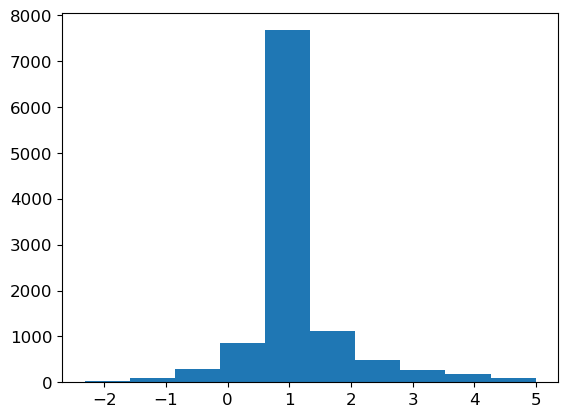

In [83]:
plt.hist(psampler.results.samples[:,1][1000:])

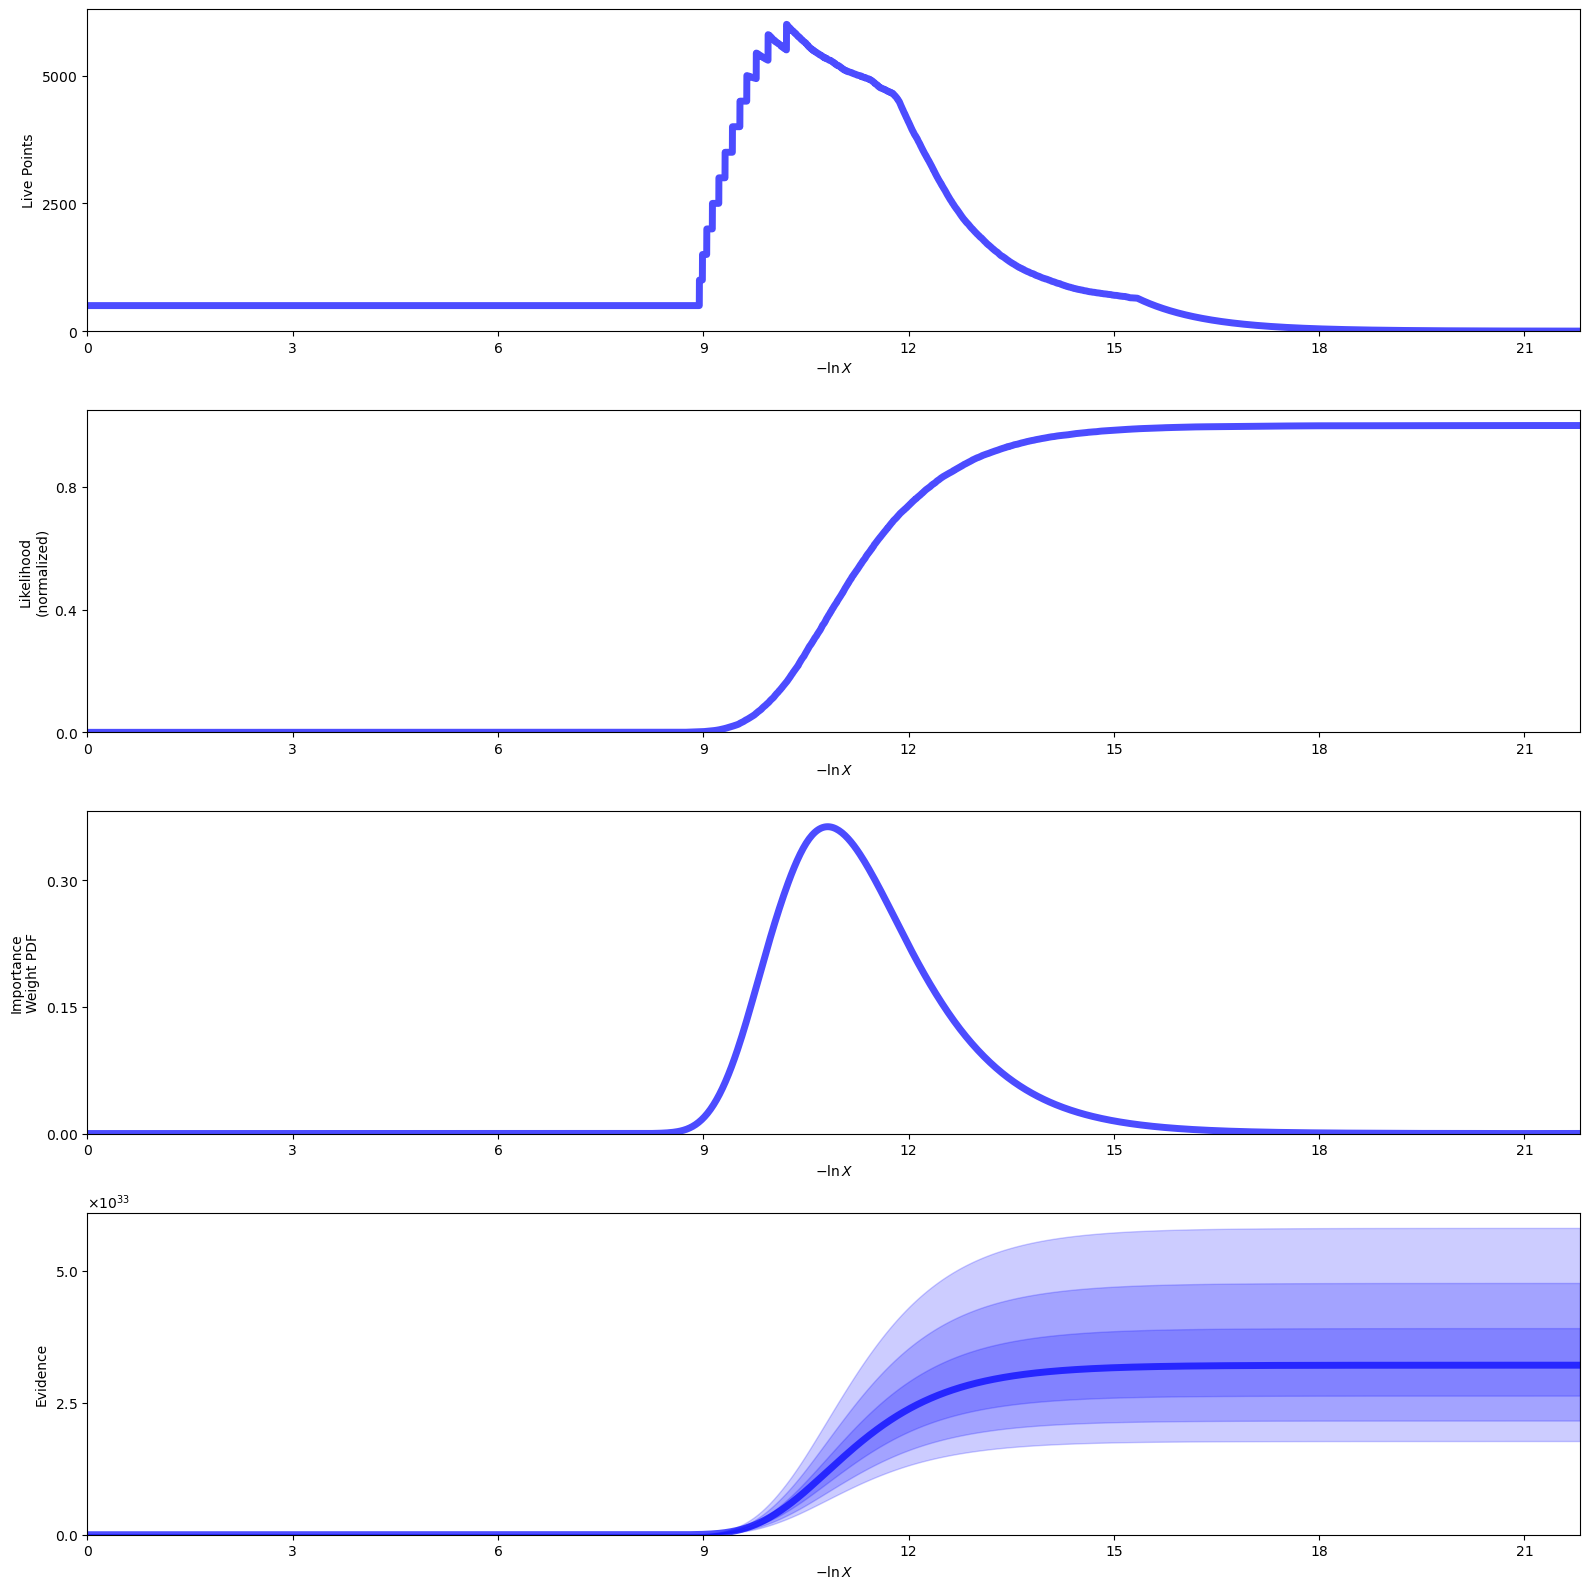

In [15]:
dres = sampler.results
samples = sampler.results.samples
from dynesty import plotting as dyplot

dyplot.runplot(dres)
plt.tight_layout()

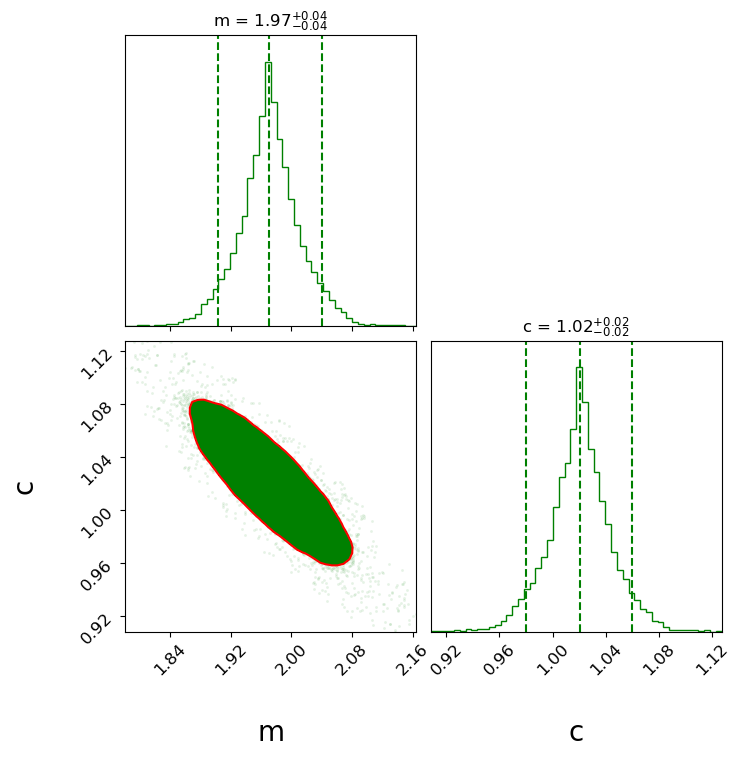

In [16]:
mask = np.where(-dres.logvol > 8)

m = samples[:, 0][mask]
c = samples[:, 1][mask]
import corner
import numpy as np

plt.rcParams.update({'font.size': 12})
fig = corner.corner(np.vstack([m, c]).T, labels=['m', 'c'], title_kwargs={"fontsize": 12}, label_kwargs={"fontsize": 20}, quantiles=[0.05, 0.5, 0.95], show_titles=True, smooth = True,  bins=50, plot_contours=True, fill_contours=True, levels=[0.95], color="g",
                   hist_kwargs={"linewidth": 1, "histtype": "step"}, contour_kwargs={"colors": ["r", "b"]}, fig_kwargs={"figsize": (20, 16)}, max_n_ticks=6, ticklabel_kwargs= {"fontsize": 10})
fig.set_size_inches(8, 8)


In [40]:
import numpy as np
import dynesty
from scipy.stats import norm
from multiprocessing import Pool, cpu_count

# Generate some sample data
np.random.seed(0)
x = np.linspace(0, 1, 100)
y = 2 * x + 1 + np.random.normal(0, 0.1, 100)

# Define the log-likelihood function
def log_likelihood(theta):
    m, c = theta
    y_model = m * x + c
    log_like = norm.logpdf(y, loc=y_model, scale=0.1).sum()
    return log_like

# Define the prior transform function
def prior_transform(utheta):
    m_m, c_m = utheta
    m_min = -5
    m_max = 5
    m = m_min + (m_max - m_min) * m_m

    c_min = -5
    c_max = 5
    c = c_min + (c_max - c_min) * c_m
    return m, c

def perform_dynesty_run(prior_bounds):
    # Generate random points within the prior bounds
    np.random.seed(42)  # Set a fixed seed for reproducibility
    n_points = 1000
    samples = np.random.uniform(prior_bounds[:, 0], prior_bounds[:, 1], size=(n_points, 2))
    
    # Compute likelihood for the generated samples
    log_likelihoods = np.array([log_likelihood(s) for s in samples])
    
    # Use a NestedSampler to get posterior samples
    sampler = dynesty.NestedSampler(log_likelihood, prior_transform, 2, n_points = 1000)
    sampler.run_nested(dlogz=0.01)
    results = sampler.results
    
    return results






In [26]:
samples = np.random.uniform(prior_bounds[:, 0], prior_bounds[:, 1], size=(10, 2))
log_likelihoods = np.array([log_likelihood(s) for s in samples])
log_likelihoods

array([-330824.48957509,   -5236.29242603,   -2089.83021341,
       -100478.70964527,  -46103.05312215, -111282.59297458,
       -170070.61708757, -371931.42958834, -149034.40216762,
       -132802.97493603])

In [41]:
if __name__ == '__main__':
    num_cores = min(cpu_count(), 16)  # Limit the number of cores to 16
    prior_bounds = np.array([[-5, 5], [-5, 5]])  # Prior bounds for slope and intercept
    
    # Divide the prior space into 16 segments
    prior_segments = np.linspace(prior_bounds[:, 0], prior_bounds[:, 1], num_cores + 1)
    
    # Create a list of prior bounds for each segment
    prior_bounds_list = [prior_segments[i:i+2] for i in range(num_cores)]
    
    # Create a multiprocessing Pool with multiple cores
    pool = Pool(processes=num_cores)

    # Perform Dynasty runs in parallel
    results = pool.map(perform_dynesty_run, prior_bounds_list)

    # Close the multiprocessing Pool
    pool.close()
    pool.join()

    # Combine the results from different cores into a single list of dictionaries
    combined_results = [r for sublist in results for r in sublist]

    # You can now analyze the combined_results as you normally would with dynesty
    # For example, to get the mean and standard deviation of the samples:
    mean_samples = np.mean([r.samples for r in combined_results], axis=0)
    std_samples = np.std([r.samples for r in combined_results], axis=0)

    # Or you can save the combined results for further analysis:
    np.save('combined_results.npy', combined_results)


7620it [00:05, 1337.82it/s, +500 | bound: 16 | nc: 1 | ncall: 29836 | eff(%): 27.215 | loglstar:   -inf < 87.949 <    inf | logz: 77.334 +/-  0.196 | dlogz:  0.000 >  0.010] 
7620it [00:05, 1341.68it/s, +500 | bound: 16 | nc: 1 | ncall: 29836 | eff(%): 27.215 | loglstar:   -inf < 87.949 <    inf | logz: 77.334 +/-  0.196 | dlogz:  0.000 >  0.010]
7620it [00:05, 1332.51it/s, +500 | bound: 16 | nc: 1 | ncall: 29836 | eff(%): 27.215 | loglstar:   -inf < 87.949 <    inf | logz: 77.334 +/-  0.196 | dlogz:  0.000 >  0.010]
7620it [00:05, 1310.54it/s, +500 | bound: 16 | nc: 1 | ncall: 29836 | eff(%): 27.215 | loglstar:   -inf < 87.949 <    inf | logz: 77.334 +/-  0.196 | dlogz:  0.000 >  0.010]
7620it [00:05, 1313.69it/s, +500 | bound: 16 | nc: 1 | ncall: 29836 | eff(%): 27.215 | loglstar:   -inf < 87.949 <    inf | logz: 77.334 +/-  0.196 | dlogz:  0.000 >  0.010]
7620it [00:05, 1310.89it/s, +500 | bound: 16 | nc: 1 | ncall: 29836 | eff(%): 27.215 | loglstar:   -inf < 87.949 <    inf | logz:

AttributeError: 'str' object has no attribute 'samples'

In [2]:
from mpi4py import MPI
import numpy as np
import dynesty
from scipy.stats import norm

# Generate some sample data (only on the master process)
if MPI.COMM_WORLD.rank == 0:
    np.random.seed(0)
    x = np.linspace(0, 1, 100)
    y = 2 * x + 1 + np.random.normal(0, 0.1, 100)
else:
    x = None
    y = None

# Broadcast the data to all processes
x = MPI.COMM_WORLD.bcast(x, root=0)
y = MPI.COMM_WORLD.bcast(y, root=0)

# Define the log-likelihood function (same as before)
# Define the log-likelihood function
def log_likelihood(theta):
    m, c = theta
    y_model = m * x + c
    log_like = norm.logpdf(y, loc=y_model, scale=0.1).sum()
    return log_like

# Define the prior transform function
def prior_transform(utheta):
    m_m, c_m = utheta
    m_min = -5
    m_max = 5
    m = m_min + (m_max - m_min) * m_m

    c_min = -5
    c_max = 5
    c = c_min + (c_max - c_min) * c_m
    return m, c

# Create a NestedSampler instance for each process
sampler = dynesty.NestedSampler(log_likelihood, prior_transform, 2, nlive=1000)

# Run the NestedSampler independently on each process with its data chunk
sampler.run_nested(dlogz=0.01)

# Gather all the results (likelihoods and posterior samples) from all processes
all_likelihoods = MPI.COMM_WORLD.gather(sampler.results['logl'], root=0)
all_samples = MPI.COMM_WORLD.gather(sampler.results['samples'], root=0)
all_logvol = MPI.COMM_WORLD.gather(sampler.results['logvol'], root=0)

# Combine the results on the master process
if MPI.COMM_WORLD.rank == 0:
    combined_likelihoods = np.concatenate(all_likelihoods)
    combined_samples = np.concatenate(all_samples)

    # You can now analyze the combined results as you normally would with dynesty
    # For example, to get the mean and standard deviation of the samples:
    mean_samples = np.mean(combined_samples, axis=0)
    std_samples = np.std(combined_samples, axis=0)

    # Or you can save the combined results for further analysis:
    np.save('combined_results.npy', combined_samples)


15420it [00:11, 1330.55it/s, +1000 | bound: 16 | nc: 1 | ncall: 60059 | eff(%): 27.340 | loglstar:   -inf < 87.949 <    inf | logz: 77.147 +/-  0.140 | dlogz:  0.000 >  0.010]


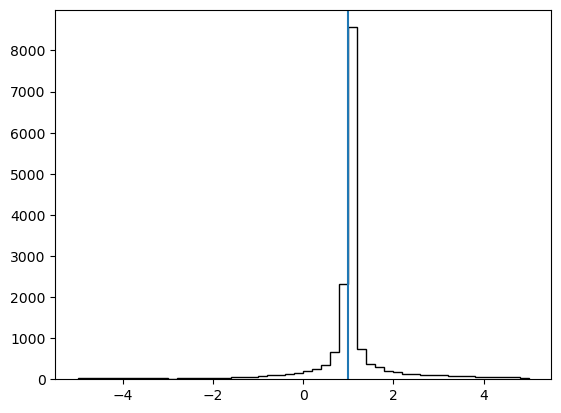

In [17]:
import matplotlib.pyplot as plt
plt.hist(all_samples[0][:,1], 50, histtype = 'step', color = 'black');


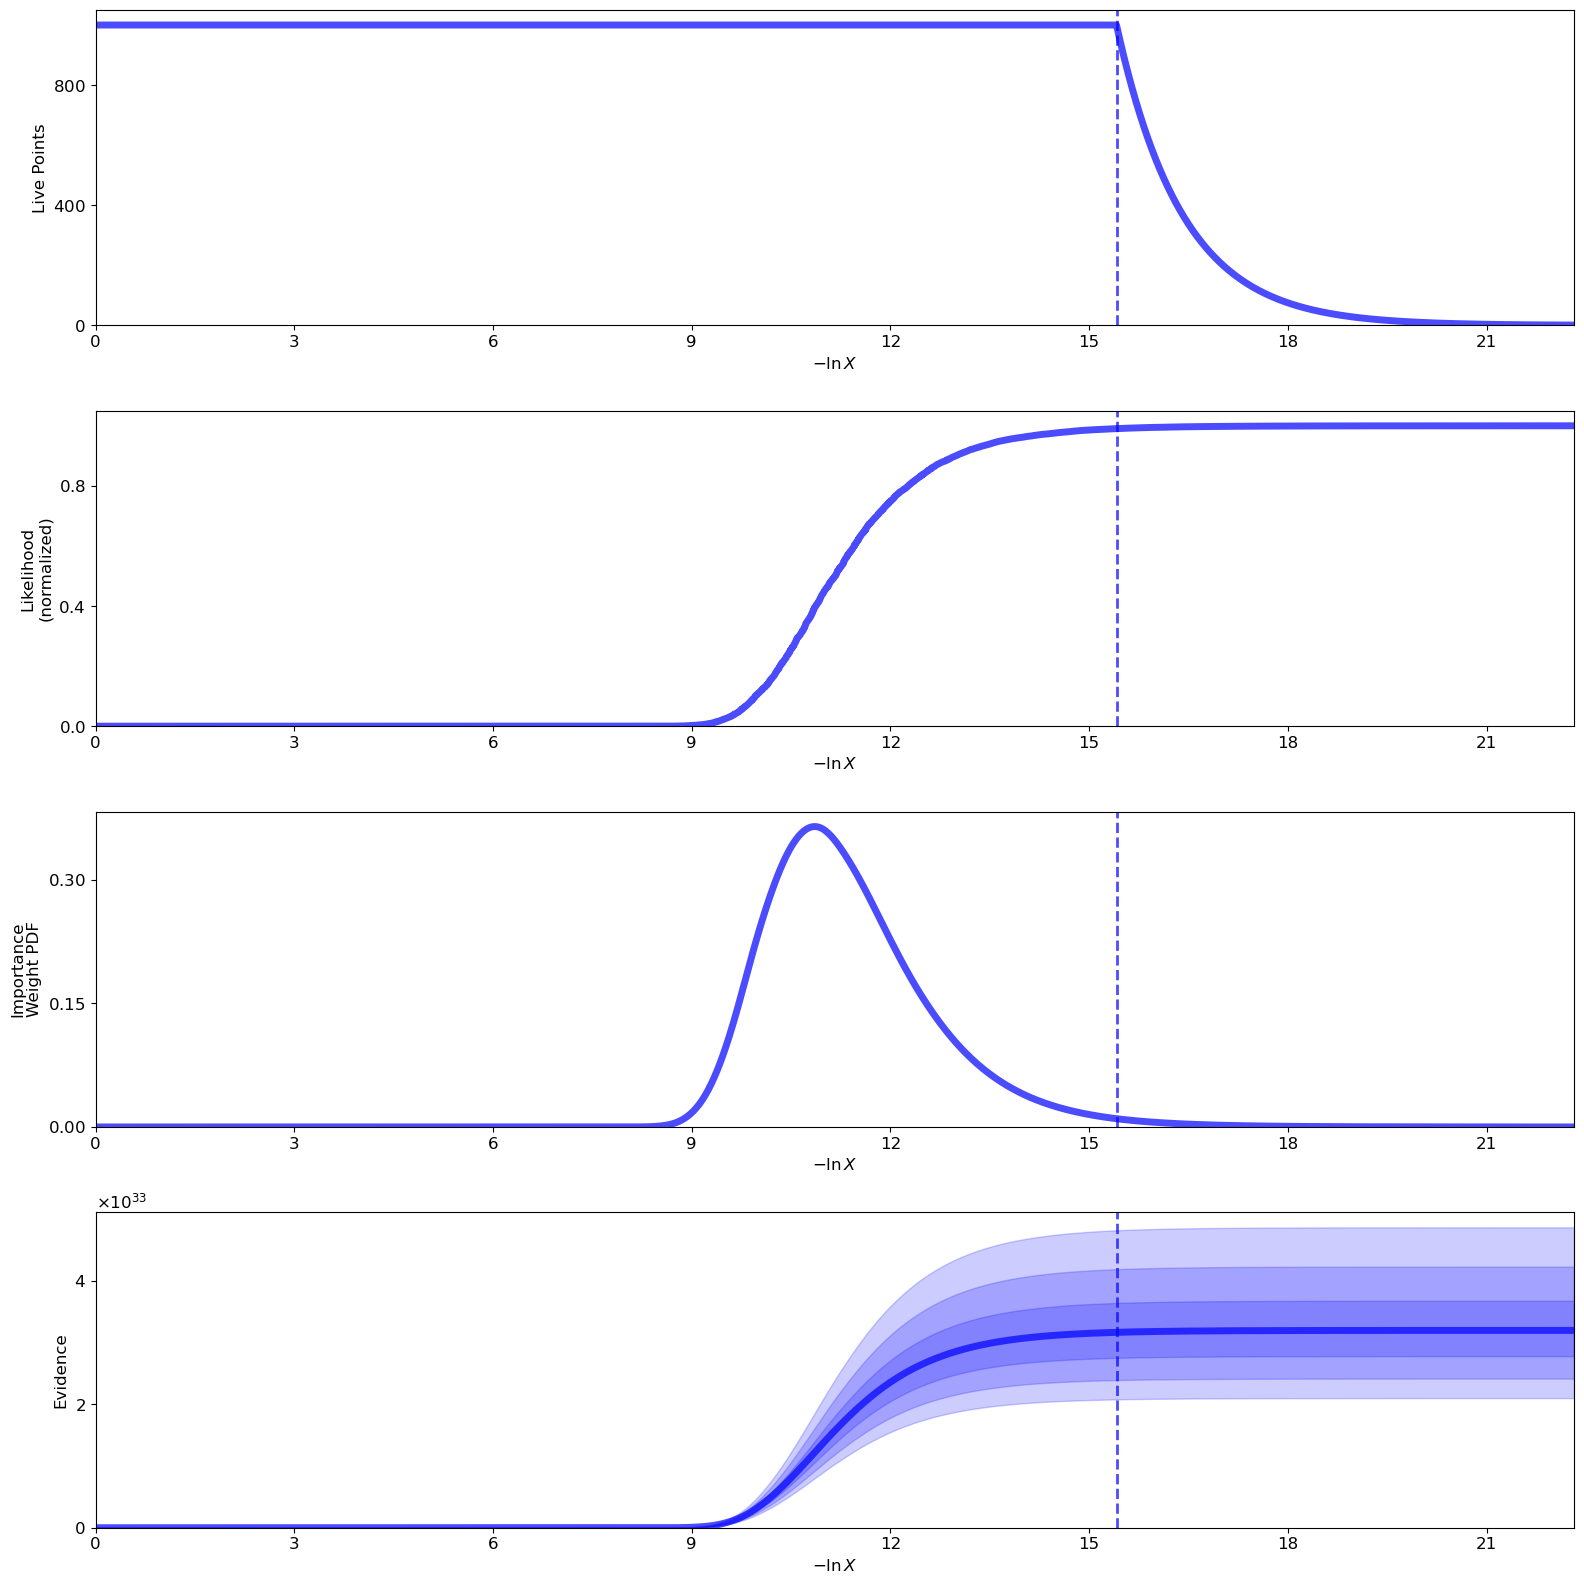

In [23]:
dres = sampler.results
samples = sampler.results.samples
from dynesty import plotting as dyplot

dyplot.runplot(dres)
plt.tight_layout()

In [31]:
mask = np.where((-dres.logvol > 9) )
m = all_samples[0][:,0][mask]
c1 = all_samples[0][:,1][mask]

Text(0, 0.5, 'c')

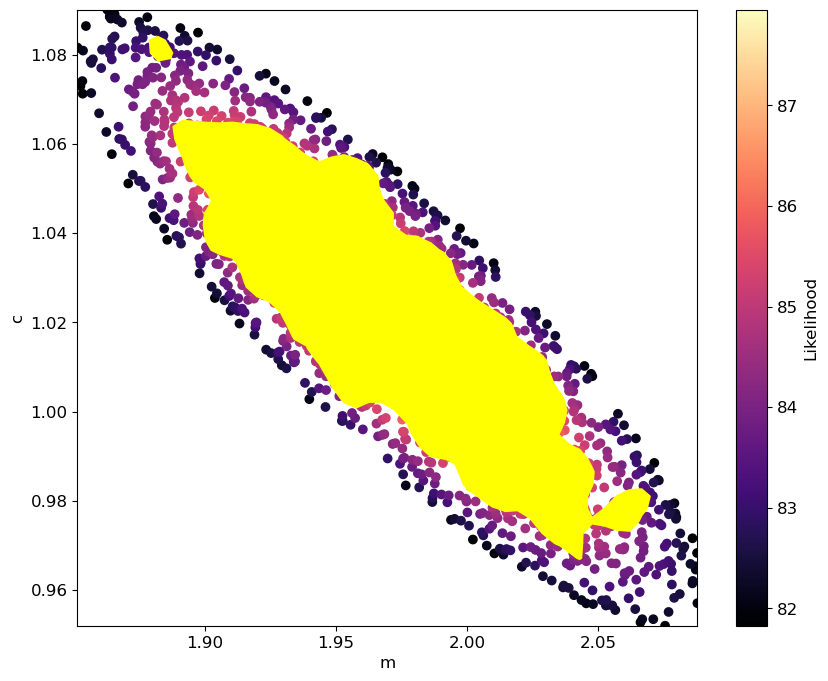

In [52]:
fig, ax = plt.subplots(figsize=(10, 8))
likelihood = dres.logl[mask]

sc = ax.scatter(m, c1, c=likelihood, cmap='magma', label='90% Region')

corner.hist2d(m, c, levels=[0.90], color='yellow', plot_density=False, plot_datapoints=True, smooth=True,
             bins=50, plot_contours=True, fill_contours=True)
plt.colorbar(sc, label = 'Likelihood')


plt.xlabel('m')
plt.ylabel('c')

In [29]:
all_samples[0][:,1]== dres.samples[:,1]

array([ True,  True,  True, ...,  True,  True,  True])

In [66]:
from mpi4py import MPI
import numpy as np
import dynesty
from scipy.stats import norm

# Generate some sample data (only on the master process)
if MPI.COMM_WORLD.rank == 0:
    np.random.seed(0)
    x = np.linspace(0, 1, 100)
    y = 2 * x + 1 + np.random.normal(0, 0.1, 100)
else:
    x = None
    y = None

# Broadcast the data to all processes
x = MPI.COMM_WORLD.bcast(x, root=0)
y = MPI.COMM_WORLD.bcast(y, root=0)

# Define the log-likelihood function
def log_likelihood(theta):
    m, c = theta
    y_model = m * x + c
    log_like = norm.logpdf(y, loc=y_model, scale=0.1).sum()
    return log_like

# Define the prior transform function
def prior_transform(utheta):
    m_m, c_m = utheta
    m_min = -5
    m_max = 5
    m = m_min + (m_max - m_min) * m_m

    c_min = -5
    c_max = 5
    c = c_min + (c_max - c_min) * c_m
    return m, c

# Divide the prior space into segments
num_segments = MPI.COMM_WORLD.Get_size()  # Number of processes
segment_bounds = np.linspace(0, 1, num_segments + 1)

# Determine the prior bounds for this process's segment
segment_idx = MPI.COMM_WORLD.rank
prior_bounds = np.array([[segment_bounds[segment_idx], segment_bounds[segment_idx + 1]], [0, 1]])

# Create a local random state for each process and seed it uniquely
local_seed = np.random.randint(0, 100000)
local_rstate = np.random.RandomState(local_seed)

# Create a NestedSampler instance for each process with its data chunk
sampler = dynesty.NestedSampler(log_likelihood, prior_transform, 2, nlive=1000, bound='multi', sample='unif', rstate=local_rstate)

# Run the NestedSampler independently on each process with its data chunk
sampler.run_nested(dlogz=0.01)

# Gather all the results (likelihoods and posterior samples) from all processes
all_likelihoods = MPI.COMM_WORLD.gather(sampler.results['logl'], root=0)
all_samples = MPI.COMM_WORLD.gather(sampler.results['samples'], root=0)

# Combine the results on the master process
if MPI.COMM_WORLD.rank == 0:
    combined_likelihoods = np.concatenate(all_likelihoods)
    combined_samples = np.concatenate(all_samples)

    # You can now analyze the combined results as you normally would with dynesty
    # For example, to get the mean and standard deviation of the samples:
    mean_samples = np.mean(combined_samples, axis=0)
    std_samples = np.std(combined_samples, axis=0)

    # Or you can save the combined results for further analysis:
    np.save('combined_results.npy', combined_samples)


15386it [00:11, 1379.14it/s, +1000 | bound: 16 | nc: 1 | ncall: 57718 | eff(%): 28.390 | loglstar:   -inf < 87.949 <    inf | logz: 77.181 +/-  0.140 | dlogz:  0.000 >  0.010]


In [65]:
all_samples

[array([[-4.93796585, -4.90715549],
        [-4.94689952, -4.88644871],
        [-4.57236862, -4.99632656],
        ...,
        [ 1.97048244,  1.02066417],
        [ 1.97047536,  1.02081954],
        [ 1.97054042,  1.02068843]])]

In [39]:
np.random.uniform(size=(1, 2))[0]

array([0.8734737, 0.6813225])

In [45]:
prior_transform(np.array([0.59814278, 0.4890157 ]))

(0.9814277999999996, -0.10984299999999969)

In [96]:
def prior_transform(utheta):
    c_m, q_m = utheta
    q_min = 0
    q_max = -1
    q = q_min + (q_max - q_min) * q_m
    
    def c_max_func(x):
        return np.sqrt(1 - x)
    
    c_min = 0
    c_max = c_max_func(q)
    
    c = c_min + (c_max - c_min) * c_m
    return  c, q

In [97]:
num_samples = 10000
samples = np.random.uniform(size=(num_samples, 2))

# Apply the prior_transform function to each sample point
prior_samples = [prior_transform(sample) for sample in samples]
prior_samples

[(1.2708778986121851, -0.8470412873491097),
 (0.9835928960803906, -0.6645845668268135),
 (0.6330187799492571, -0.6898144216488314),
 (0.4298522454044127, -0.4127848963527916),
 (0.9188419956366459, -0.3784360963736204),
 (0.36949384720714107, -0.46738815891364194),
 (0.9264318386730616, -0.8951338936087987),
 (1.0537362546526585, -0.27386691757522386),
 (0.819687404544982, -0.3190582862945006),
 (0.12578487864267446, -0.6906303101907617),
 (1.007180827721769, -0.03650794806628532),
 (0.28244269823564616, -0.9230178543151328),
 (0.6380064719837037, -0.1608309477938561),
 (0.010443963786045398, -0.5429464307296613),
 (0.602067142087739, -0.582227733356787),
 (0.8909731512587655, -0.8211148697658226),
 (1.0218481716520482, -0.23838953651767736),
 (0.20749437978898505, -0.5828369476239927),
 (0.18473288193409956, -0.18299135871283656),
 (0.4049080565198199, -0.06140534406763409),
 (1.0588708927910753, -0.19571950520957715),
 (0.23906060936124895, -0.5100543890283136),
 (0.9973498203945668,

In [98]:
diff = []
for i in prior_samples:
    diff.append(np.sqrt(1 - i[1]) - i[0])

In [100]:
diff

[0.08818107264296593,
 0.3065949068486302,
 0.6669098418022726,
 0.7587540377494295,
 0.25522618652894724,
 0.8418641341153258,
 0.4502067826102435,
 0.0749208755579398,
 0.32881522335558167,
 1.174457525753814,
 0.010909516042616696,
 1.1042864946189401,
 0.4394121782140066,
 1.231709984293524,
 0.655799199522842,
 0.4585137400320771,
 0.09098134652118817,
 1.0506141002809941,
 0.9029211801246216,
 0.6253372269285606,
 0.03461870716384752,
 0.9897820937656864,
 0.04798213564405929,
 0.4852647212071355,
 0.7394991637685586,
 0.6193804763001383,
 0.7988694456909147,
 1.0464770315487766,
 1.0983043562788077,
 0.1030421797262,
 0.908215747709789,
 0.9845272252206514,
 1.2180507629777955,
 0.2662191716345733,
 1.1657266706278082,
 1.2290603673317968,
 0.8661232180227407,
 1.066074269415324,
 0.05545218135924612,
 1.1223407553842488,
 0.4654893837943006,
 0.9362414873386868,
 0.30087345213829897,
 1.1022444746528384,
 0.1532081365070581,
 0.07027272484800218,
 0.9638251667593808,
 0.2076084

# GW 150914

In [1]:
import sys
sys.path.append('/mnt/pfs/akash.mishra/pytimedomain/')
import matplotlib.pyplot as plt
import readligo as rl
import matplotlib.mlab as mlab, matplotlib.pyplot as plt, numpy as np, os, sys, warnings

import numpy as np
from scipy.linalg import toeplitz
from Data import DataProcessor
import noise
from scipy.signal      import butter, filtfilt, welch, tukey, decimate
import likelihood_class

from noise import detector
import waveform
import lal
import matplotlib.pyplot as plt
import readligo as rl
import matplotlib.mlab as mlab, matplotlib.pyplot as plt, numpy as np, os, sys, warnings

import numpy as np
import pandas as pd
from scipy.linalg import toeplitz
from scipy.interpolate import interp2d

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [9]:
import dill
with open('/mnt/pfs/akash.mishra/pytimedomain/job_files/GW150914/ringdown_GW150914.pkl', 'rb') as file:
    # Load the object from the pickle file
    data_150914_kerr = dill.load(file)

# GW 150914 Braneworld Dynamical Prior

In [10]:
# Open the pickle file in binary read mode
import dill
with open('/mnt/pfs/akash.mishra/pytimedomain/job_files/braneworld/dyn_prior/GW150914/ringdown_GW150914_dynprior_updated.pkl', 'rb') as file:
    # Load the object from the pickle file
    data_150914_bw = dill.load(file)

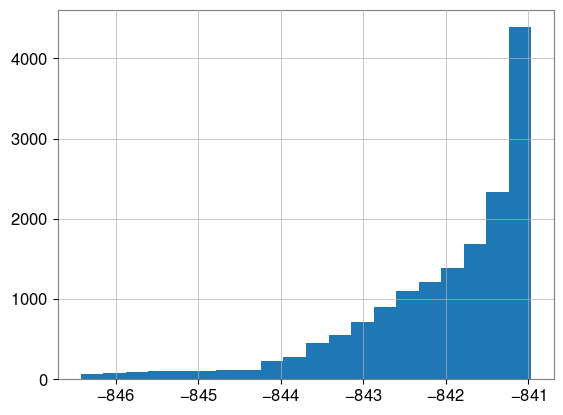

In [21]:
mask_150914 = np.where((-data_150914_bw.logvol > 12) )
plt.hist(data_150914_bw['logz'][mask_150914], 20);

/home/akash.mishra/miniconda3/envs/igwn-py38/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


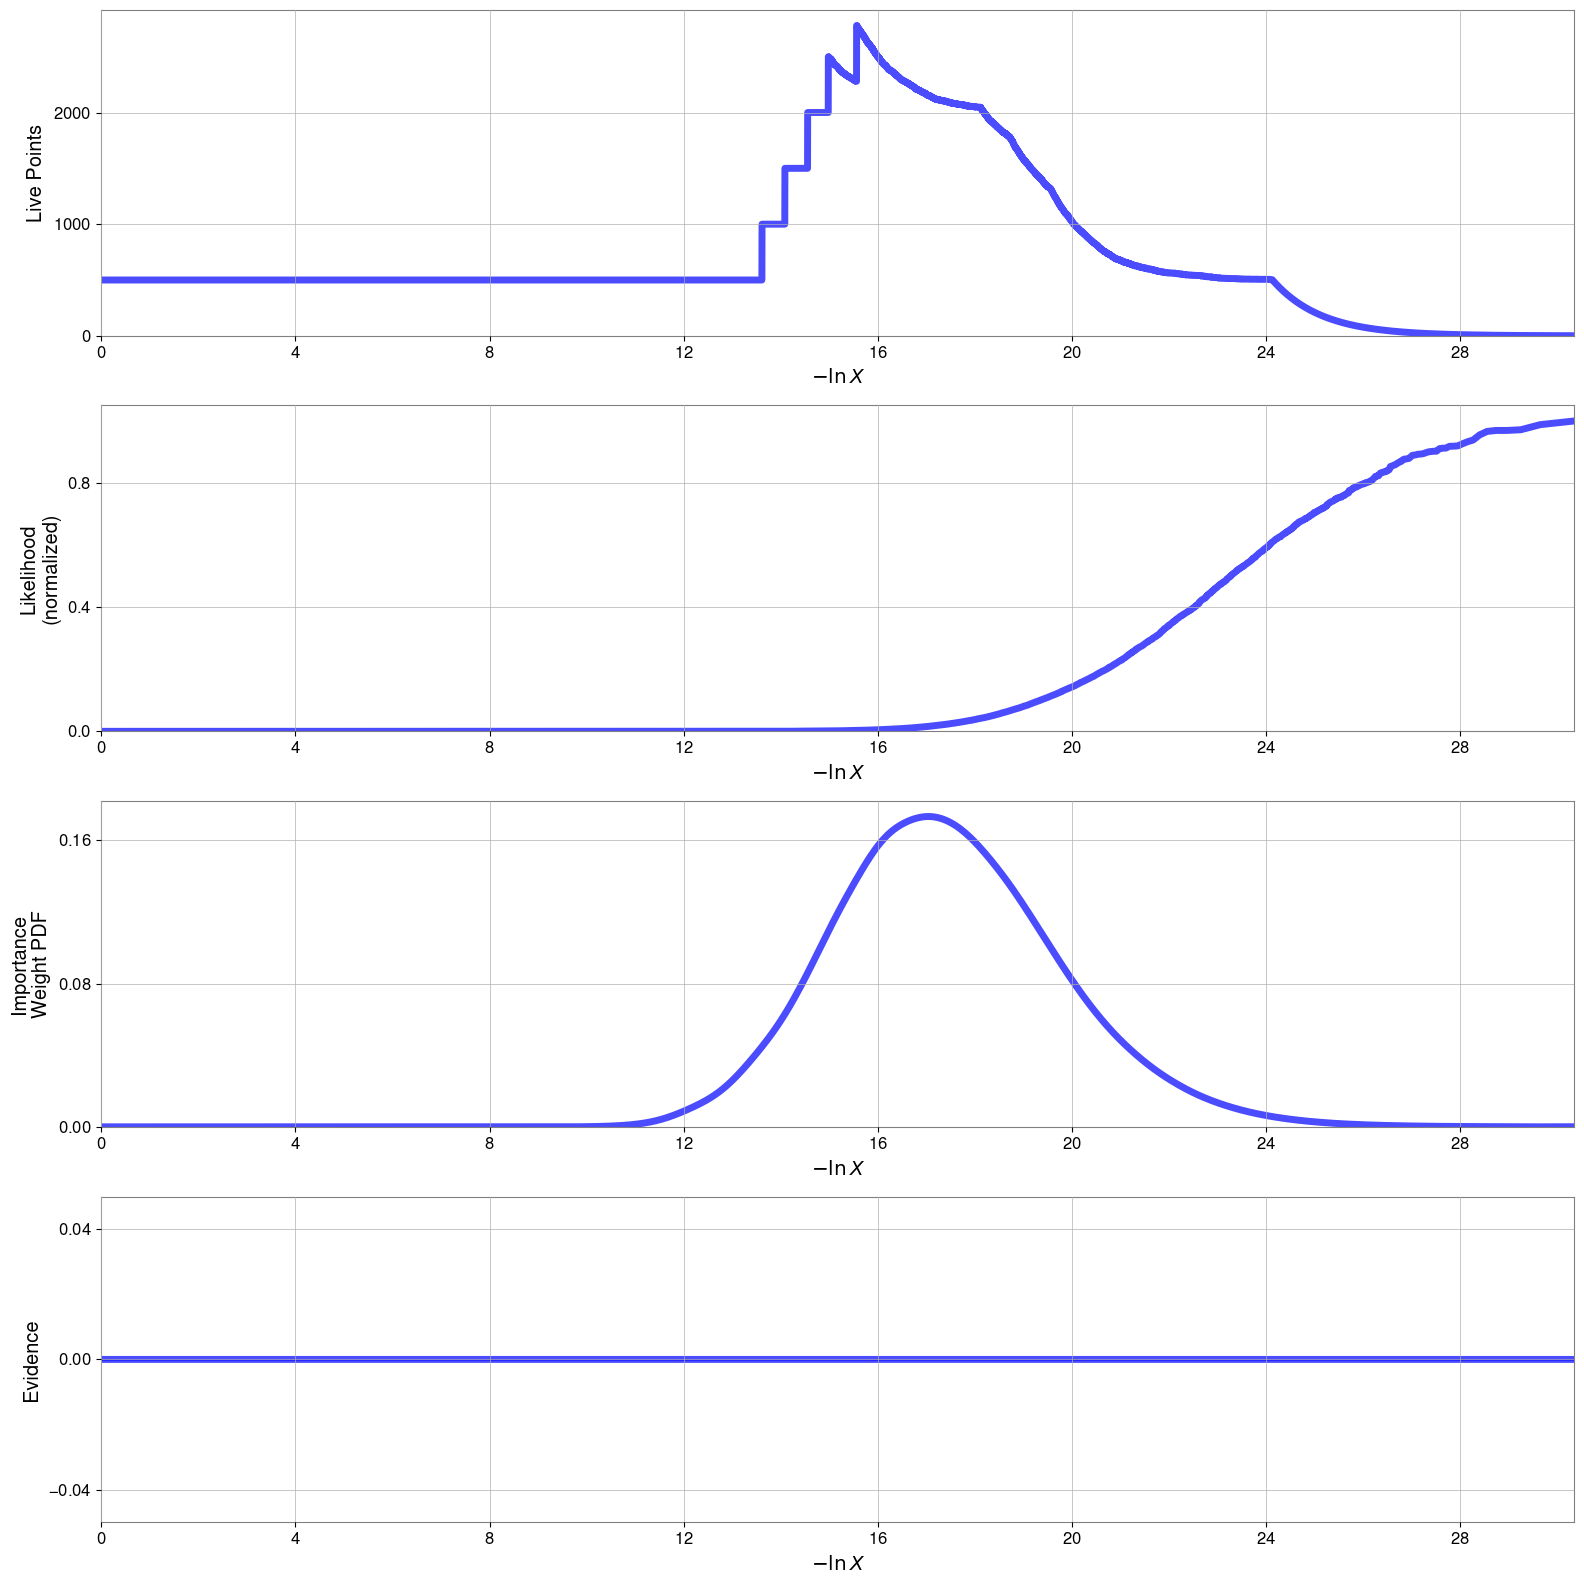

In [3]:
from dynesty import plotting as dyplot
dyplot.runplot(data_150914)
plt.tight_layout()

In [4]:
mask_150914 = np.where((-data_150914.logvol > 12) )
m_150914 = data_150914.samples[:, 0][mask_150914]
c_150914 = data_150914.samples[:, 1][mask_150914]
q_150914 = data_150914.samples[:, 2][mask_150914]

a0_150914 = data_150914.samples[:, 3][mask_150914]
a1_150914 = data_150914.samples[:, 4][mask_150914]

p0_150914 = data_150914.samples[:, 5][mask_150914]
p1_150914 = data_150914.samples[:, 6][mask_150914]

i_150914 = data_150914.samples[:, 7][mask_150914]
phi_150914 = data_150914.samples[:, 8][mask_150914]


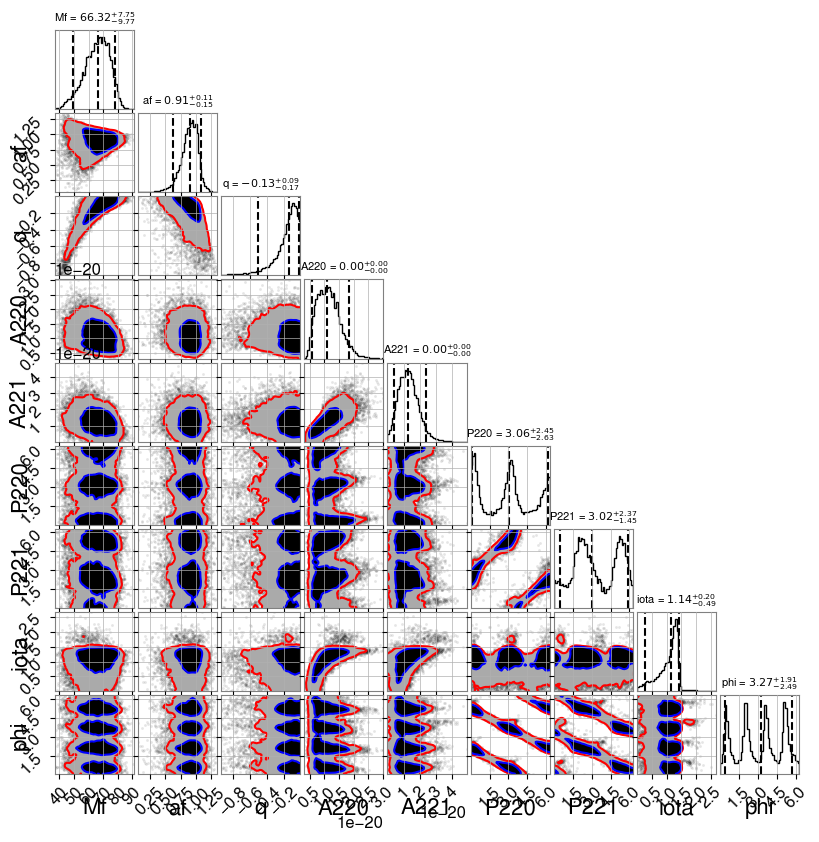

In [28]:
import corner
import numpy as np

plt.rcParams.update({'font.size': 12})
fig = corner.corner(np.vstack([m_150914, c_150914, q_150914, a0_150914, a1_150914, p0_150914, p1_150914, i_150914, phi_150914]).T, labels=['Mf', 'af', 'q', 'A220', 'A221', 'P220', 'P221', 'iota', 'phi'], title_kwargs={"fontsize": 8}, label_kwargs={"fontsize": 16}, quantiles=[0.05, 0.5, 0.95], show_titles=True, smooth = True,  bins=50, plot_contours=True, fill_contours=True, levels=[0.95, 0.67], color="black",
                   hist_kwargs={"linewidth": 1, "histtype": "step"}, contour_kwargs={"colors": ["r", "b"]}, fig_kwargs={"figsize": (30, 25)}, max_n_ticks=6, ticklabel_kwargs= {"fontsize": 4}, labelpad_value = 4)
fig.set_size_inches(8, 8)
#plt.savefig('/mnt/pfs/akash.mishra/pytimedomain/job_files/braneworld/dyn_prior/GW150914/GW150914_corner_dynamical.pdf')

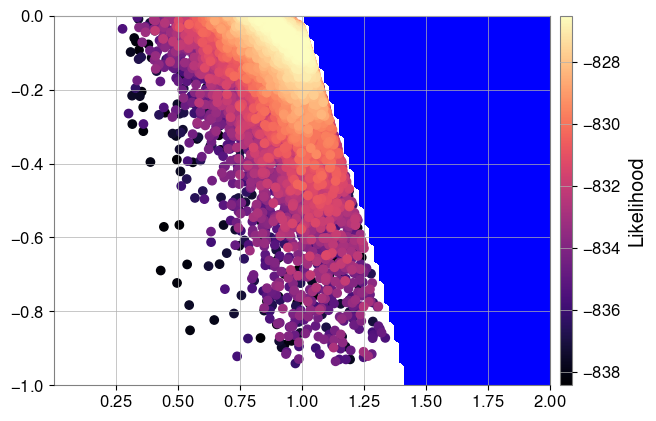

In [225]:
posterior_a = c  # Example posterior values for a
posterior_s = q 

a_min, a_max = 1e-3, 2
q_min, q_max = -1, 0.0
# Create the mesh grid
num_points = 100  # Adjust the number of points as needed
a_values = np.linspace(a_min, a_max, num_points)
q_values = np.linspace(q_min, q_max, num_points)
a_grid, q_grid = np.meshgrid(a_values, q_values)
mask_1 = 1 - a_grid**2 - q_grid > 0
fig, ax = plt.subplots()
ax.contourf(a_grid, q_grid, mask_1, levels=[0, 0.2, 1], colors=['blue', 'white'])
#ax.scatter(posterior_a, posterior_s, color='red', label='90% Region')
likelihood = data_150914_cp.logl[mask_150914]

ax.scatter(c_150914 , q_150914, c=likelihood, cmap='magma', label='90% Region')
ax.colorbar(label='Likelihood')

#ax.scatter(0.9, -0.15, marker='+', color='white', label='Truth Value')

Text(0, 0.5, 'q')

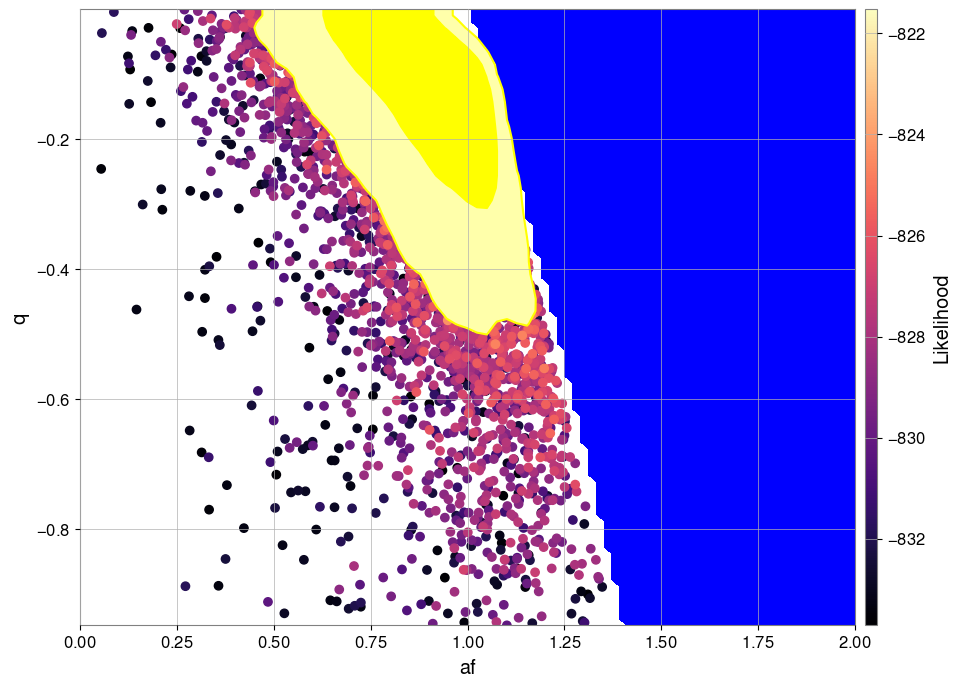

In [6]:
import corner
a_min, a_max = 1e-3, 2
q_min, q_max = -1, 0.0
# Create the mesh grid
num_points = 100  # Adjust the number of points as needed
a_values = np.linspace(a_min, a_max, num_points)
q_values = np.linspace(q_min, q_max, num_points)
a_grid, q_grid = np.meshgrid(a_values, q_values)
mask_1 = 1 - a_grid**2 - q_grid > 0
fig, ax = plt.subplots(figsize=(10, 8))
ax.contourf(a_grid, q_grid, mask_1, levels=[0, 0.2, 1], colors=['blue', 'white'])
# plt.text(1.4, -0.5, 'Extremal Region', fontsize=14, color='white', weight='bold')
#ax.scatter(posterior_a, posterior_s, color='red', label='90% Region')
likelihood = data_150914.logl[mask_150914]

ax.scatter(c_150914, q_150914, c=likelihood, cmap='magma', label='90% Region')
ax.colorbar(label='Likelihood')
corner.hist2d(c_150914, q_150914, levels=[0.90, 0.67], color='yellow', plot_density=False, plot_datapoints=True, smooth=True,
             bins=50, plot_contours=True, fill_contours=True)

plt.xlim([0, 2])

plt.xlabel('af')
plt.ylabel('q')
#plt.savefig('/mnt/pfs/akash.mishra/pytimedomain/job_files/braneworld/dyn_prior/GW150914/GW150914_af_q_smooth.pdf')

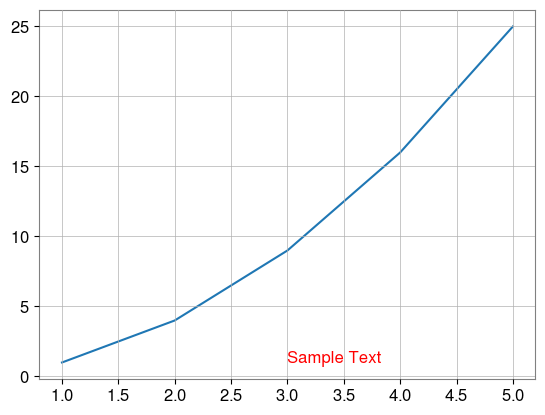

In [24]:
import matplotlib.pyplot as plt

# Generate some data
x = [1, 2, 3, 4, 5]
y = [1, 4, 9, 16, 25]

# Create a plot
plt.plot(x, y)

# Add text to the plot
plt.text(3, 1, 'Sample Text', fontsize=12, color='red')

# Customize the text properties
# fontsize, color, etc.

# Display the plot
plt.show()


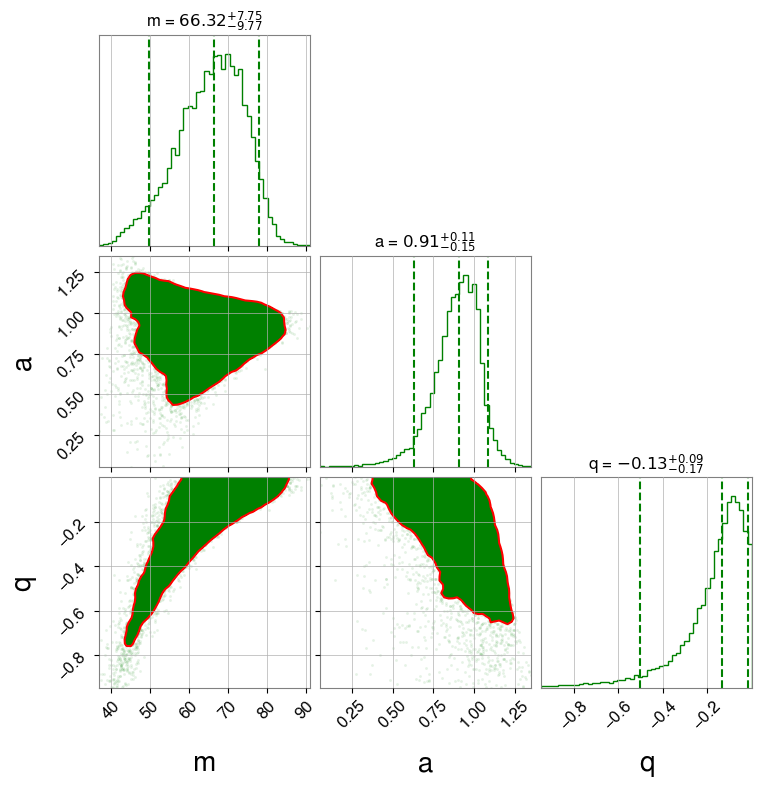

In [16]:
import corner
import numpy as np

plt.rcParams.update({'font.size': 12})
fig = corner.corner(np.vstack([m_150914, c_150914, q_150914]).T, labels=['m', 'a', 'q'], title_kwargs={"fontsize": 12}, label_kwargs={"fontsize": 20}, quantiles=[0.05, 0.5, 0.95], show_titles=True, smooth = True,  bins=50, plot_contours=True, fill_contours=True, levels=[0.95], color="g",
                   hist_kwargs={"linewidth": 1, "histtype": "step"}, contour_kwargs={"colors": ["r", "b"]}, fig_kwargs={"figsize": (20, 16)}, max_n_ticks=6, ticklabel_kwargs= {"fontsize": 10})
fig.set_size_inches(8, 8)
plt.savefig('/mnt/pfs/akash.mishra/pytimedomain/job_files/braneworld/dyn_prior/GW150914/GW150914_corner_dynamical.pdf')

# GW 190521

In [3]:
import sys
sys.path.append('/mnt/pfs/akash.mishra/pytimedomain/')
import matplotlib.pyplot as plt
import readligo as rl
import matplotlib.mlab as mlab, matplotlib.pyplot as plt, numpy as np, os, sys, warnings
import pandas as pd
import numpy as np
from scipy.linalg import toeplitz
from Data import DataProcessor
import noise
from scipy.signal      import butter, filtfilt, welch, tukey, decimate
import likelihood_class

from noise import detector
import waveform
import lal
from scipy.linalg import toeplitz
from scipy.interpolate import interp2d
warnings.filterwarnings("ignore", category=DeprecationWarning)

def interpolated_functionb(datafile):
    qnm_data = pd.read_pickle(datafile)
    q_list = list(qnm_data.keys())
    a_list = list(qnm_data[0.0].keys())
    x = a_list
    y = q_list  
    z_real = []
    z_imag = []
    for i in range(len(q_list)):
        z_real.append(tuple(np.real(list(qnm_data[q_list[i]].values())))[0:194])
        z_imag.append(tuple(np.imag(list(qnm_data[q_list[i]].values())))[0:194])
    
    wreal = interp2d(x, y, np.array(z_real, dtype=object))
    wimag = interp2d(x, y, np.array(z_imag, dtype=object))
    
    return wreal, wimag

real_220_interp, imag_220_interp = interpolated_functionb('/mnt/pfs/akash.mishra/pytimedomain/data_files/braneworld_qnm_files/qnm_data_220_updated.pickle')
real_221_interp, imag_221_interp = interpolated_functionb('/mnt/pfs/akash.mishra/pytimedomain/data_files/braneworld_qnm_files/qnm_data_221_updated.pickle')

interpolants_bw = {(2,2,2,0):{'freq': real_220_interp, 'tau': imag_220_interp}, (2,2,2,1):{'freq': real_221_interp, 'tau': imag_221_interp}}

kwargs = {'f_min':20, 'f_max':2047, 'data_duration':4096,'triggertime': 1242459857.460, 'srate':4096, 'signal_chunk_size':4, 'noise_chunk_size':4,
                'output': '/mnt/pfs/akash.mishra/pytimedomain/', 'window': 1, 'alpha-window': 0.1, 'fft-acf': True, 'acf-file':'', 'acf-simple-norm': False}

file_h1 = '/mnt/pfs/akash.mishra/pytimedomain/data_files/GW190521_074359/H-H1_GWOSC_4KHZ_R1-1242457810-4096.hdf5'
h1 = DataProcessor(file_h1)


h1_data = detector('H1', file_h1, **kwargs)

file_l1 = '/mnt/pfs/akash.mishra/pytimedomain/data_files/GW190521_074359/L-L1_GWOSC_4KHZ_R1-1242457810-4096.hdf5'

l1_data = detector('L1', file_l1, **kwargs)
cov_inverse = {'H1': np.linalg.inv(toeplitz(h1_data.acf[0:820])), 'L1': np.linalg.inv(toeplitz(l1_data.acf[0:820]))}


def time_d(det_list, ref_det, ra, dec, tM_gps):
    td = {}
    ref_det_lal =  lal.cached_detector_by_prefix[ref_det]
    for d in det_list:
        det = lal.cached_detector_by_prefix[d]
        td[ref_det + '_' + d] = lal.ArrivalTimeDiff(det.location, ref_det_lal.location, ra, dec, tM_gps)
    return td


det_class = {'H1': h1_data, 'L1':l1_data}
ra=4.90
dec=0.33
psi=1.47
trigger_time = 1242459857.460
t_start = 0.0
n_duration = 820 
ref_det = 'H1' 
time_delay = time_d(['H1', 'L1'], ref_det, ra, dec,  trigger_time)

* Computing the one-sided PSD with the Welch method for comparison with the standard ACF.

* Computing the one-sided PSD with the Welch method for comparison with the standard ACF.



In [4]:
def loglikelihood(theta):
    mass_f, chi, q,  amp0, amp1, iota, phi = theta
    amps = {(2,2,2,0): amp0, (2,2,2,1): amp1}
    phase = {(2,2,2,0): 0.0, (2,2,2,1): 0.0}
    r = 400
    
    logL = 0.0

    for d in det_class.keys():
        lal_det = lal.cached_detector_by_prefix[d]
        dt   = time_delay['{0}_'.format(ref_det)+d]
        tref = lal.LIGOTimeGPS(t_start+dt+trigger_time)
        time_array_raw = det_class[d].time - (trigger_time+dt)
        time_array     = time_array_raw[time_array_raw >= t_start][:n_duration]
        data           = det_class[d].time_series[time_array_raw >= t_start][:n_duration]
        hp, hc = waveform.BraneworldBH(t_start, mass_f, chi, q, amps, phase, r, iota, phi, interpolants_bw).waveform(time_array)
        prediction = likelihood_class.project(hp, hc, lal_det, ra, dec, psi, tref)
        dd = likelihood_class.inner_product_direct_inversion(data,       data,       cov_inverse[d])
        dh = likelihood_class.inner_product_direct_inversion(data,       prediction, cov_inverse[d])
        hh = likelihood_class.inner_product_direct_inversion(prediction, prediction, cov_inverse[d])
        residuals_inner_product = dd - 2. * dh + hh
        logL += -0.5*residuals_inner_product #+ log_normalisation
    return logL

# prior transform
def prior_transform(utheta):
    mass_fm, chi_m,  q_m, amp0_m, amp1_m, iota_m, phi_m = utheta
    
    mass_f = 20 + (150-20) * mass_fm
    q_min = -0.95
    q_max = 0.0
    q = q_min + (q_max - q_min) * q_m
    
    
    def a_max_func(x):
        return np.sqrt(1 - x)-0.02
    
    a_min = 0.05
    
    
    a_max = a_max_func(q)
    chi = a_min + (a_max - a_min) * chi_m
    
    
    
    amp0 = 1e-24 + (1e-19 - 1e-24) * amp0_m
    amp1 = 1e-24 + (1e-19 - 1e-24) * amp1_m
    

    iota =  np.pi * iota_m
    phi = 2 * np.pi * phi_m
    
    return mass_f, chi, q, amp0, amp1, iota, phi




In [15]:
import dynesty
dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim=7,sample = 'unif',
                                        nlive=1000)
dsampler.run_nested()

25689it [11:44, 36.48it/s, batch: 7 | bound: 131 | nc: 1 | ncall: 123450 | eff(%): 20.809 | loglstar: -859.913 < -850.415 < -853.223 | logz: -868.181 +/-  0.223 | stop:  0.851]        


# GW 190521 Braneworld Dynamical prior

In [5]:
# Open the pickle file in binary read mode
import dill
with open('/mnt/pfs/akash.mishra/pytimedomain/job_files/braneworld/dyn_prior/GW190521/ringdown_GW190521_dynprior_updated.pkl', 'rb') as file:
    # Load the object from the pickle file
    data_190521 = dill.load(file)

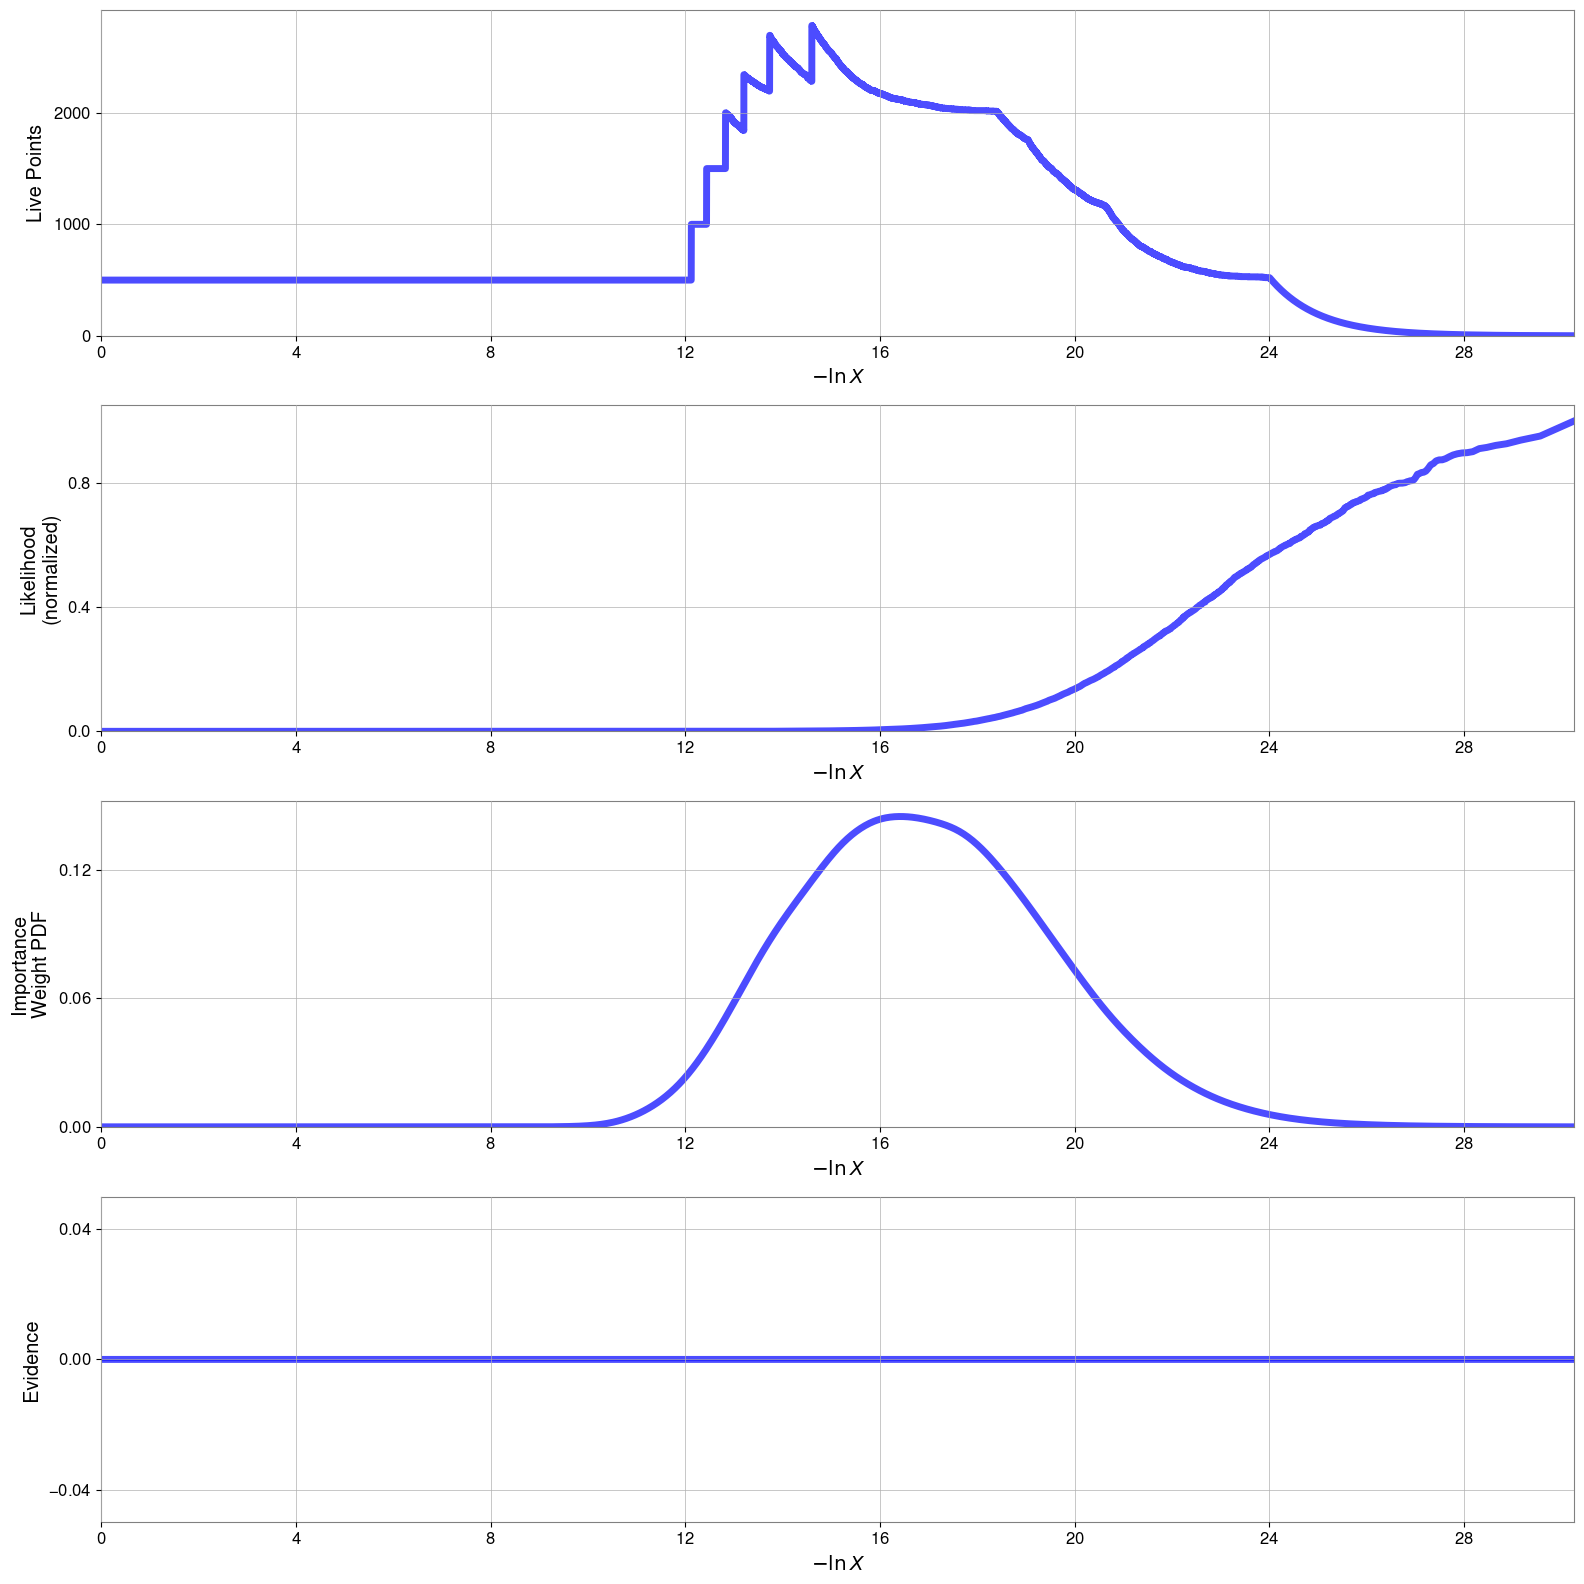

In [17]:
from dynesty import plotting as dyplot

dyplot.runplot(data_190521)
plt.tight_layout()

In [9]:
mask_190521 = np.where((-data_190521.logvol > 12))
m_190521 = data_190521.samples[:, 0][mask_190521]
c_190521 = data_190521.samples[:, 1][mask_190521]
q_190521 = data_190521.samples[:, 2][mask_190521]

a0_190521 = data_190521.samples[:, 3][mask_190521]
a1_190521 = data_190521.samples[:, 4][mask_190521]

p0_190521 = data_190521.samples[:, 5][mask_190521]
p1_190521 = data_190521.samples[:, 6][mask_190521]

i_190521 = data_190521.samples[:, 7][mask_190521]
phi_190521 = data_190521.samples[:, 8][mask_190521]


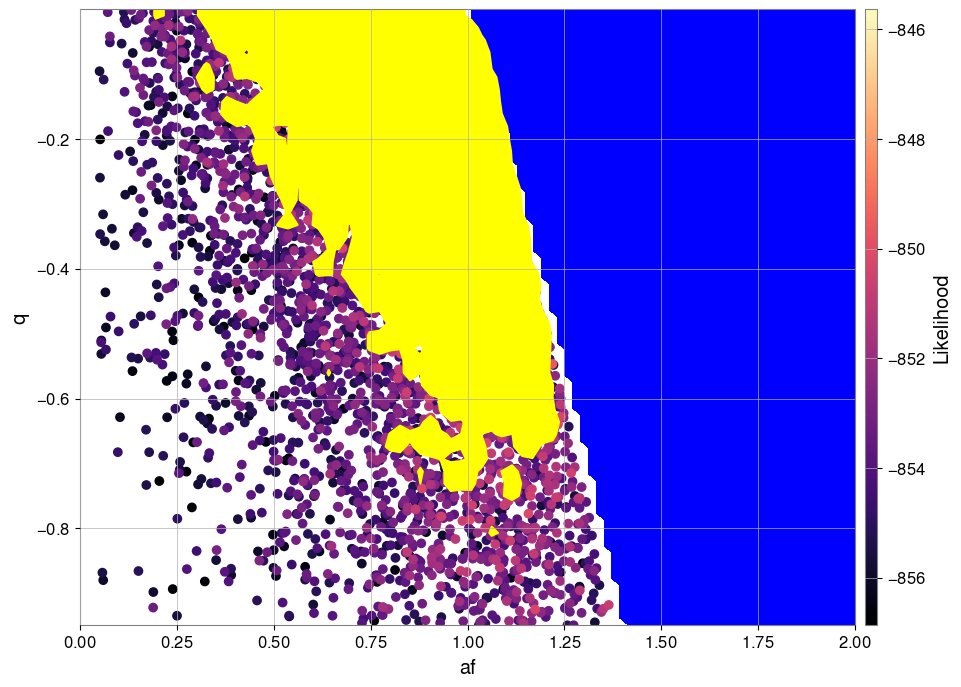

In [10]:
import corner
a_min, a_max = 1e-3, 2
q_min, q_max = -1, 0.0
# Create the mesh grid
num_points = 100  # Adjust the number of points as needed
a_values = np.linspace(a_min, a_max, num_points)
q_values = np.linspace(q_min, q_max, num_points)
a_grid, q_grid = np.meshgrid(a_values, q_values)
mask_1 = 1 - a_grid**2 - q_grid > 0
fig, ax = plt.subplots(figsize=(10, 8))
ax.contourf(a_grid, q_grid, mask_1, levels=[0, 0.2, 1], colors=['blue', 'white'])
# plt.text(1.4, -0.5, 'Extremal Region', fontsize=14, color='white', weight='bold')
#ax.scatter(posterior_a, posterior_s, color='red', label='90% Region')
likelihood = data_190521.logl[mask_190521]

ax.scatter(c_190521, q_190521, c=likelihood, cmap='magma', label='90% Region')
ax.colorbar(label='Likelihood')
corner.hist2d(c_190521, q_190521, levels=[0.90], color='yellow', plot_density=False, plot_datapoints=True, smooth=0.6,
             bins=50, plot_contours=True, fill_contours=True)

plt.xlim([0, 2])

plt.xlabel('af')
plt.ylabel('q')
plt.savefig('/mnt/pfs/akash.mishra/pytimedomain/job_files/braneworld/dyn_prior/GW190521/GW190521_af_q.pdf')

In [124]:
likelihood[0], likelihood[-1]

(-859.9590924460521, -850.3946658160604)

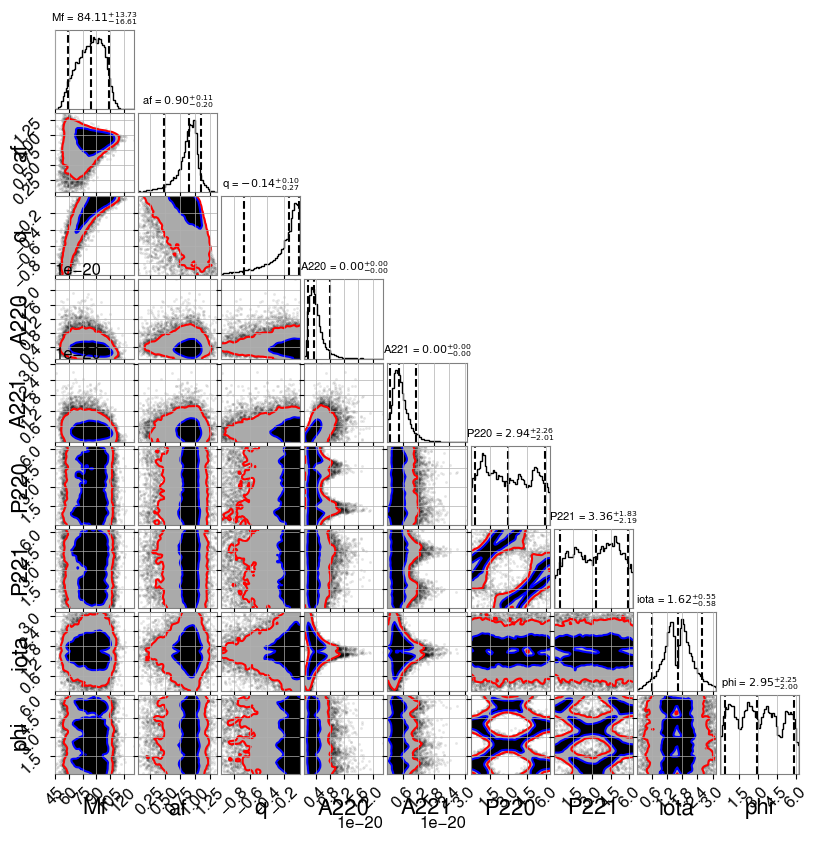

In [26]:
import corner
import numpy as np

plt.rcParams.update({'font.size': 12})
fig = corner.corner(np.vstack([m_190521, c_190521, q_190521, a0_190521, a1_190521, p0_190521, p1_190521, i_190521, phi_190521]).T, labels=['Mf', 'af', 'q', 'A220', 'A221', 'P220', 'P221', 'iota', 'phi'], title_kwargs={"fontsize": 8}, label_kwargs={"fontsize": 16}, quantiles=[0.05, 0.5, 0.95], show_titles=True, smooth = True,  bins=50, plot_contours=True, fill_contours=True, levels=[0.95, 0.67], color="black",
                   hist_kwargs={"linewidth": 1, "histtype": "step"}, contour_kwargs={"colors": ["r", "b"]}, fig_kwargs={"figsize": (30, 25)}, max_n_ticks=6, ticklabel_kwargs= {"fontsize": 4}, labelpad_value = 4)
fig.set_size_inches(8, 8)
plt.savefig('/mnt/pfs/akash.mishra/pytimedomain/job_files/braneworld/dyn_prior/GW190521/GW190521_corner.pdf')

# GW 170729 Braneworld Dynamical Prior

In [11]:
# Open the pickle file in binary read mode
import dill
with open('/mnt/pfs/akash.mishra/pytimedomain/job_files/braneworld/dyn_prior/GW170729/ringdown_GW170729_dynprior_updated.pkl', 'rb') as file:
    # Load the object from the pickle file
    data_170729 = dill.load(file)

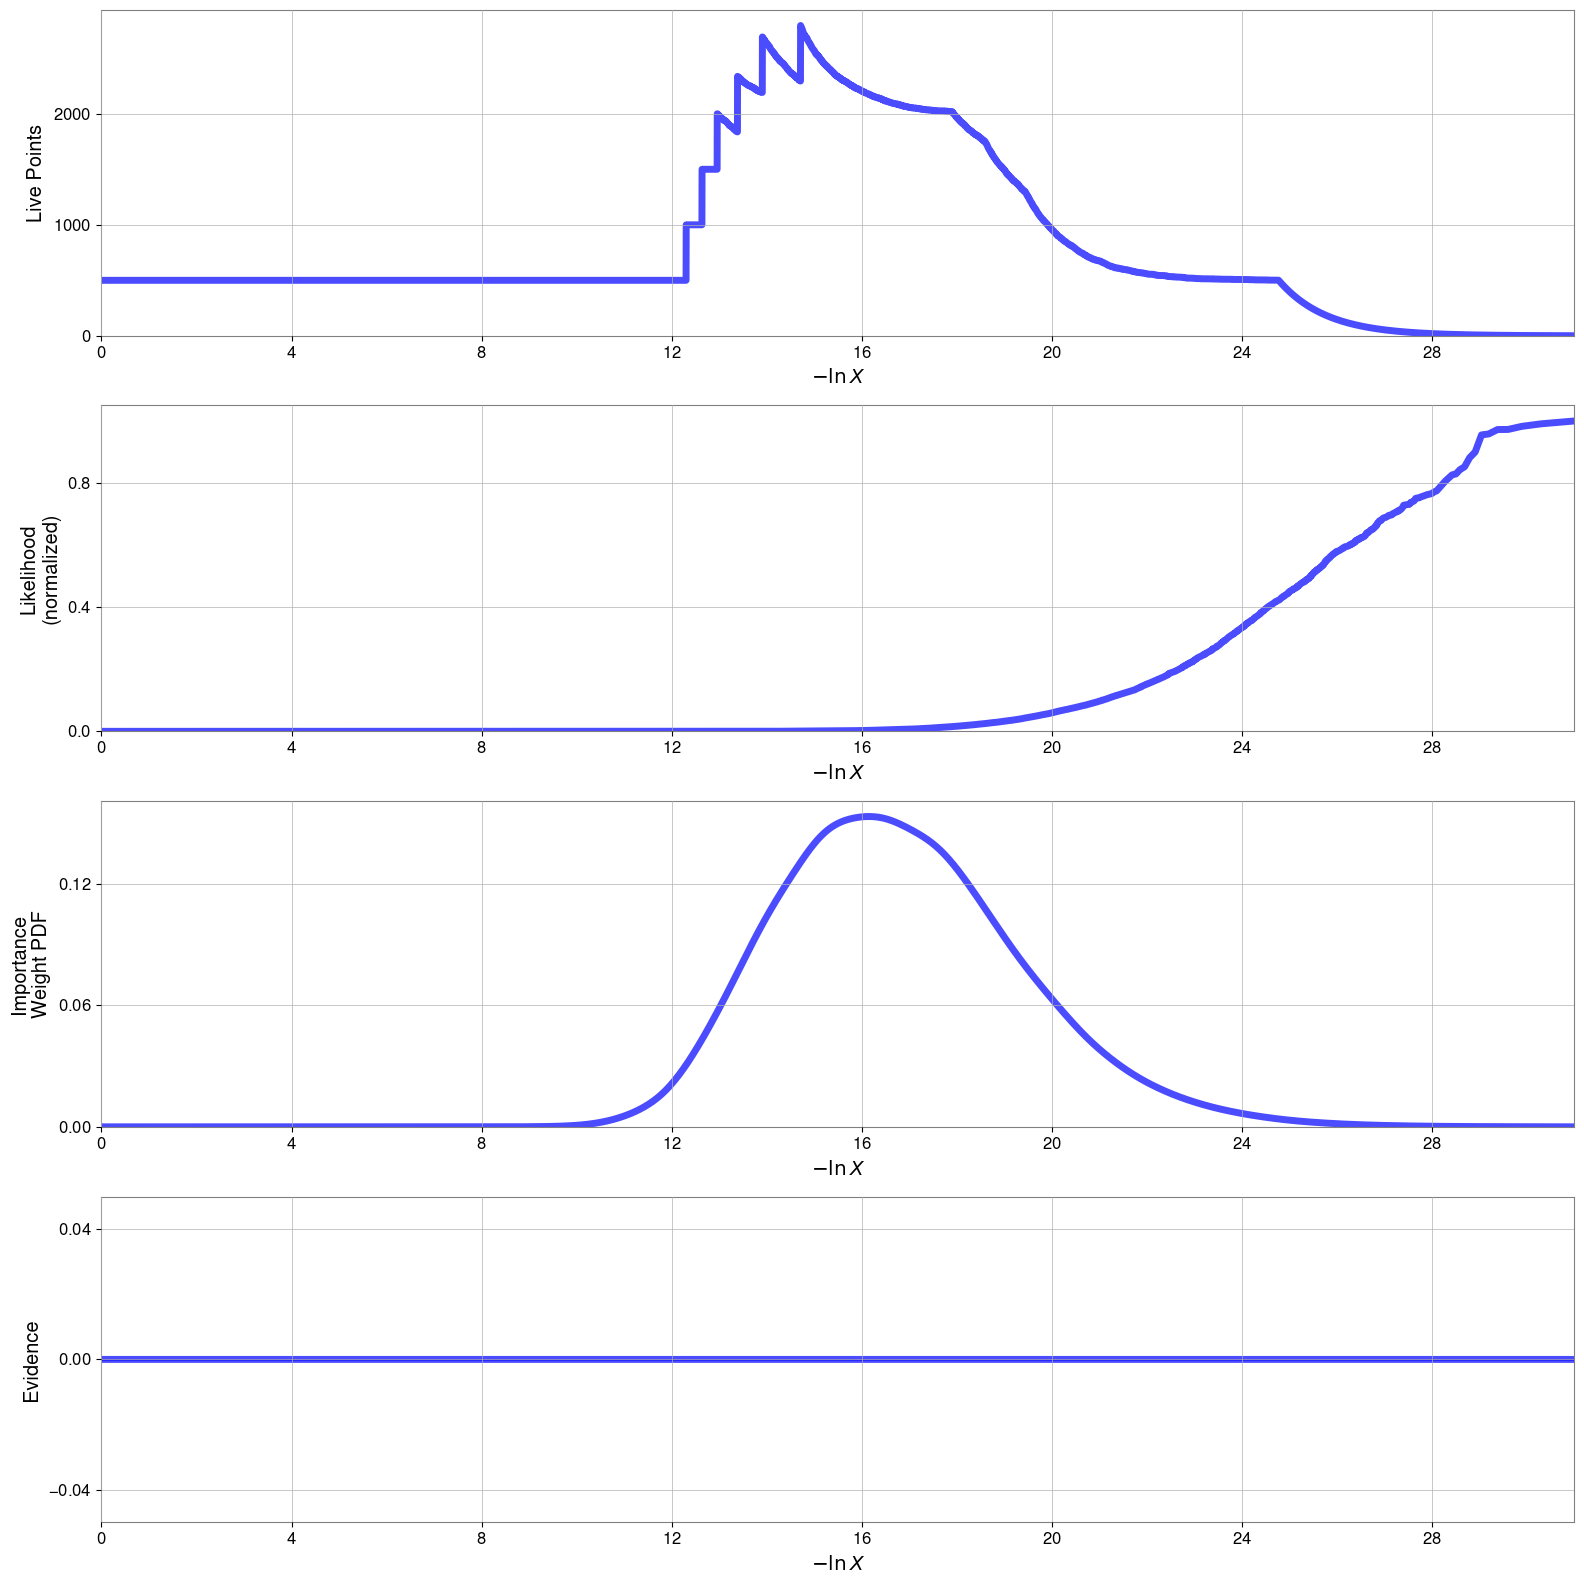

In [20]:
from dynesty import plotting as dyplot

dyplot.runplot(data_170729)
plt.tight_layout()

In [14]:
mask_170729 = np.where((-data_170729.logvol > 12))
m_170729 = data_170729.samples[:, 0][mask_170729]
c_170729 = data_170729.samples[:, 1][mask_170729]
q_170729 = data_170729.samples[:, 2][mask_170729]

a0_170729 = data_170729.samples[:, 3][mask_170729]
a1_170729 = data_170729.samples[:, 4][mask_170729]

p0_170729 = data_170729.samples[:, 5][mask_170729]
p1_170729 = data_170729.samples[:, 6][mask_170729]

i_170729 = data_170729.samples[:, 7][mask_170729]
phi_170729 = data_170729.samples[:, 8][mask_170729]



Text(0, 0.5, 'q')

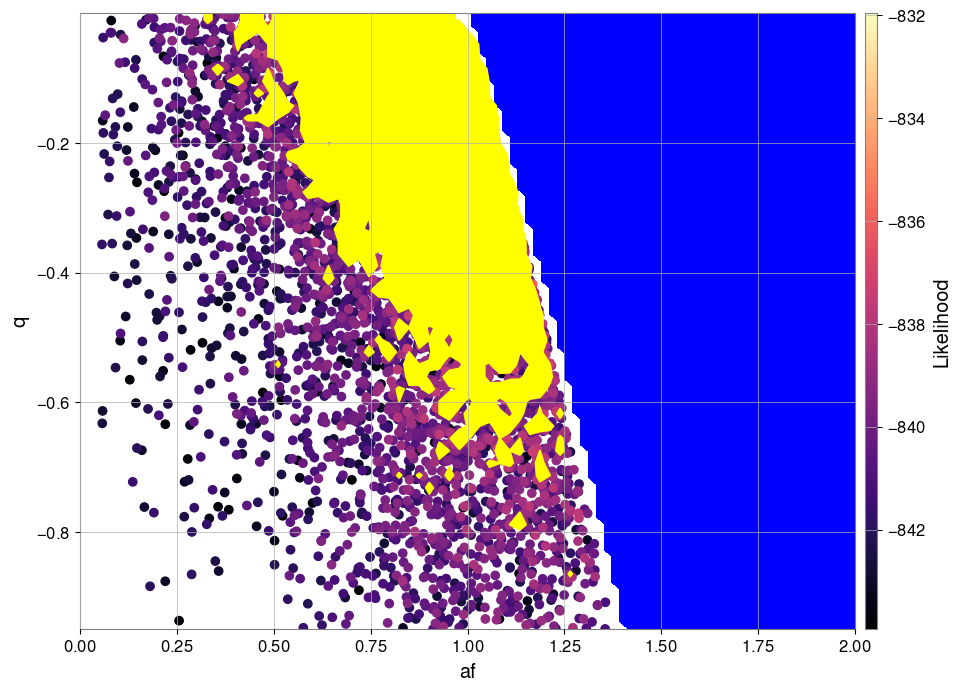

In [15]:
import corner
a_min, a_max = 1e-3, 2
q_min, q_max = -1, 0.0
# Create the mesh grid
num_points = 100  # Adjust the number of points as needed
a_values = np.linspace(a_min, a_max, num_points)
q_values = np.linspace(q_min, q_max, num_points)
a_grid, q_grid = np.meshgrid(a_values, q_values)
mask_1 = 1 - a_grid**2 - q_grid > 0
fig, ax = plt.subplots(figsize=(10, 8))
ax.contourf(a_grid, q_grid, mask_1, levels=[0, 0.2, 1], colors=['blue', 'white'])
# plt.text(1.4, -0.5, 'Extremal Region', fontsize=14, color='white', weight='bold')
#ax.scatter(posterior_a, posterior_s, color='red', label='90% Region')
likelihood = data_170729.logl[mask_170729]

ax.scatter(c_170729, q_170729, c=likelihood, cmap='magma', label='90% Region')
ax.colorbar(label='Likelihood')
corner.hist2d(c_170729, q_170729, levels=[0.90], color='yellow', plot_density=False, plot_datapoints=True, smooth=0.0,
             bins=50, plot_contours=True, fill_contours=True)

plt.xlim([0, 2])

plt.xlabel('af')
plt.ylabel('q')
#plt.savefig('/mnt/pfs/akash.mishra/pytimedomain/job_files/braneworld/dyn_prior/GW190521/GW190521_af_q.pdf')

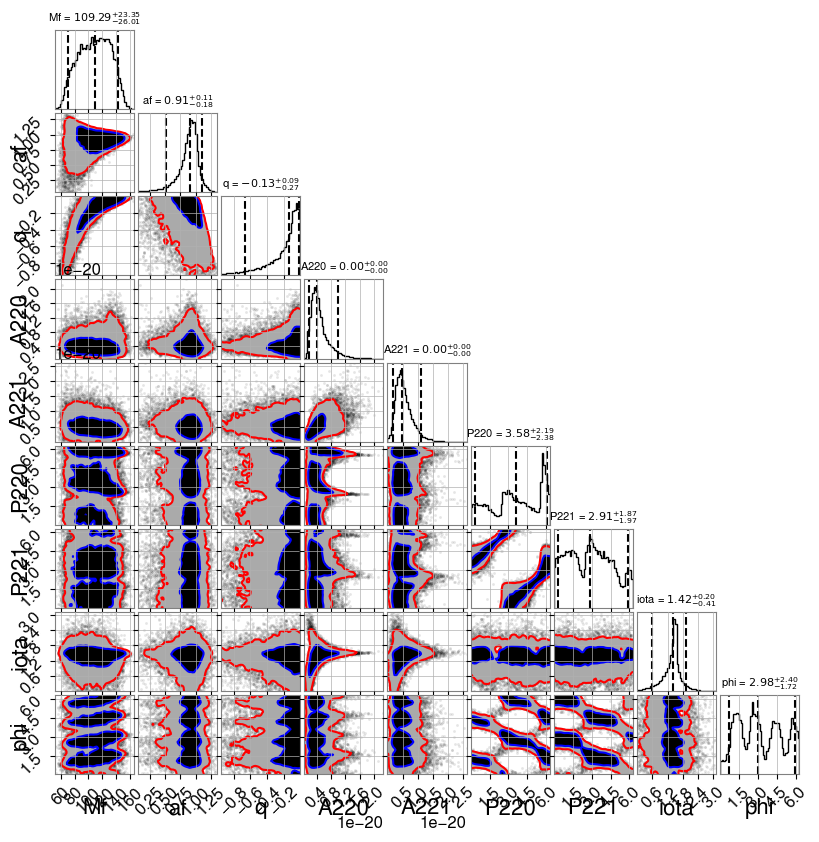

In [31]:
import corner
import numpy as np

plt.rcParams.update({'font.size': 12})
fig = corner.corner(np.vstack([m_170729, c_170729, q_170729, a0_170729, a1_170729, p0_170729, p1_170729, i_170729, phi_170729]).T, labels=['Mf', 'af', 'q', 'A220', 'A221', 'P220', 'P221', 'iota', 'phi'], title_kwargs={"fontsize": 8}, label_kwargs={"fontsize": 16}, quantiles=[0.05, 0.5, 0.95], show_titles=True, smooth = True,  bins=50, plot_contours=True, fill_contours=True, levels=[0.95, 0.67], color="black",
                   hist_kwargs={"linewidth": 1, "histtype": "step"}, contour_kwargs={"colors": ["r", "b"]}, fig_kwargs={"figsize": (30, 25)}, max_n_ticks=6, ticklabel_kwargs= {"fontsize": 4}, labelpad_value = 4)
fig.set_size_inches(8, 8)

# GW 170104 Braneworld Dynamical Prior

In [16]:
# Open the pickle file in binary read mode
import dill
with open('/mnt/pfs/akash.mishra/pytimedomain/job_files/braneworld/dyn_prior/GW170104/ringdown_GW170104_dynprior_updated.pkl', 'rb') as file:
    # Load the object from the pickle file
    data_170104 = dill.load(file)

/home/akash.mishra/miniconda3/envs/igwn-py38/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


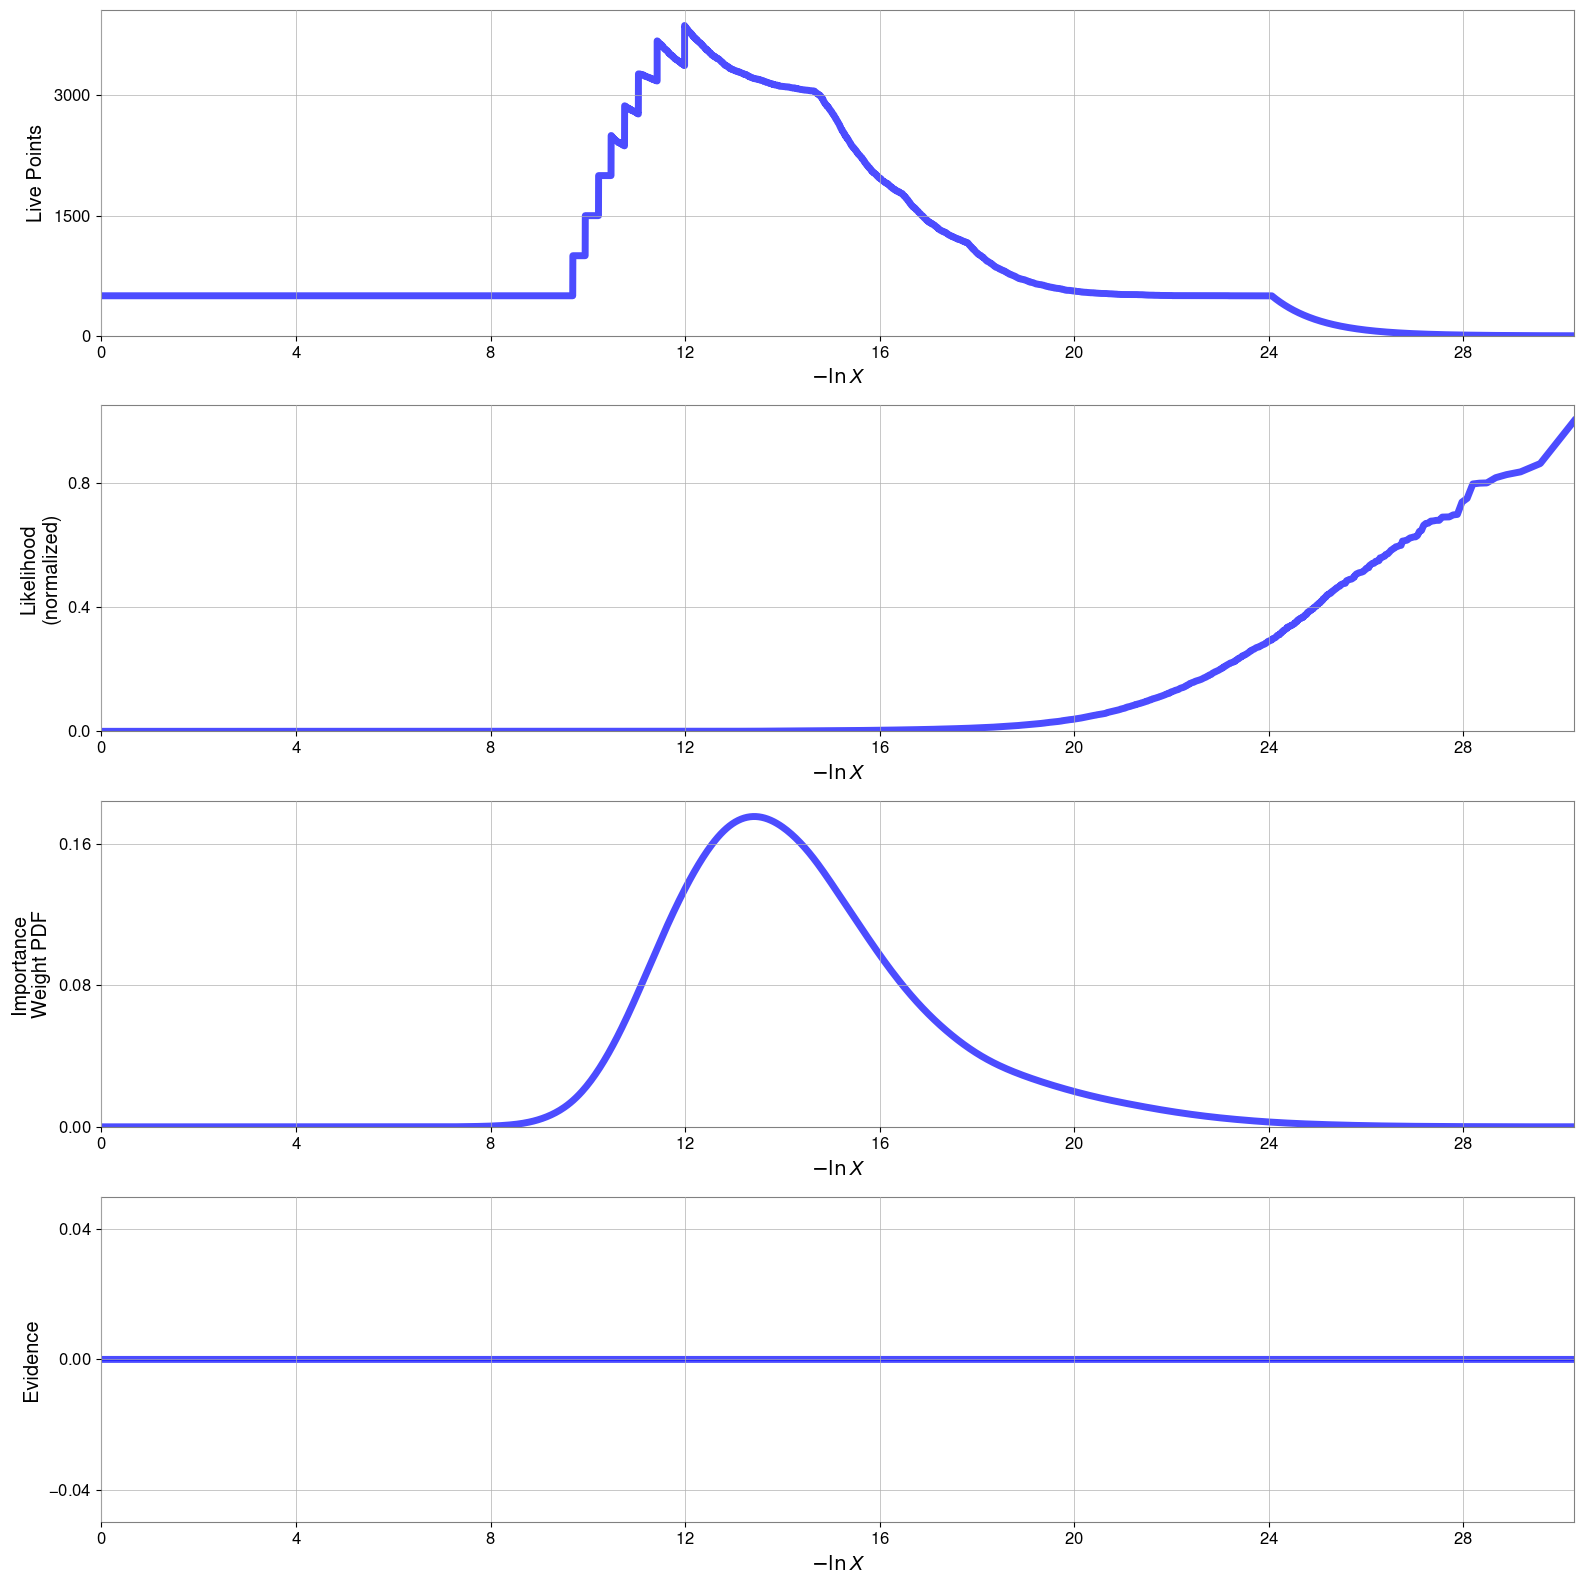

In [4]:
from dynesty import plotting as dyplot

dyplot.runplot(data_170104)
plt.tight_layout()

In [17]:
mask_170104 = np.where((-data_170104.logvol > 12))
m_170104 = data_170104.samples[:, 0][mask_170104]
c_170104 = data_170104.samples[:, 1][mask_170104]
q_170104 = data_170104.samples[:, 2][mask_170104]

a0_170104 = data_170104.samples[:, 3][mask_170104]
a1_170104 = data_170104.samples[:, 4][mask_170104]

p0_170104 = data_170104.samples[:, 5][mask_170104]
p1_170104 = data_170104.samples[:, 6][mask_170104]

i_170104 = data_170104.samples[:, 7][mask_170104]
phi_170104 = data_170104.samples[:, 8][mask_170104]

Text(0, 0.5, 'q')

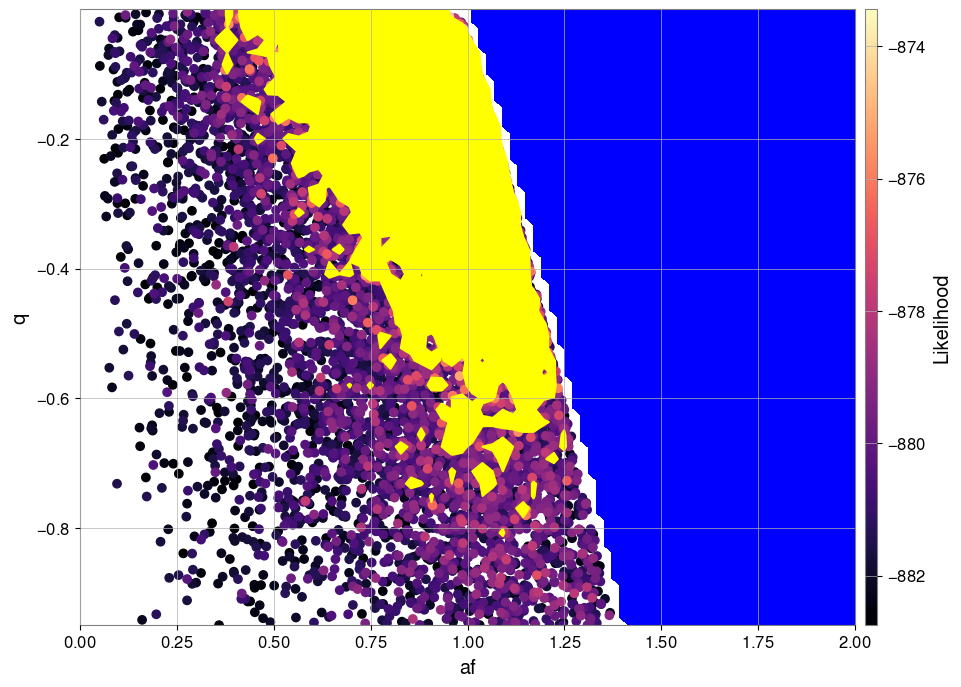

In [18]:
import corner
a_min, a_max = 1e-3, 2
q_min, q_max = -1, 0.0
# Create the mesh grid
num_points = 100  # Adjust the number of points as needed
a_values = np.linspace(a_min, a_max, num_points)
q_values = np.linspace(q_min, q_max, num_points)
a_grid, q_grid = np.meshgrid(a_values, q_values)
mask_1 = 1 - a_grid**2 - q_grid > 0
fig, ax = plt.subplots(figsize=(10, 8))
ax.contourf(a_grid, q_grid, mask_1, levels=[0, 0.2, 1], colors=['blue', 'white'])
# plt.text(1.4, -0.5, 'Extremal Region', fontsize=14, color='white', weight='bold')
#ax.scatter(posterior_a, posterior_s, color='red', label='90% Region')
likelihood = data_170104.logl[mask_170104]

ax.scatter(c_170104, q_170104, c=likelihood, cmap='magma', label='90% Region')
ax.colorbar(label='Likelihood')
corner.hist2d(c_170104, q_170104, levels=[0.80], color='yellow', plot_density=False, plot_datapoints=True, smooth=False,
             bins=50, plot_contours=True, fill_contours=True)

plt.xlim([0, 2])

plt.xlabel('af')
plt.ylabel('q')

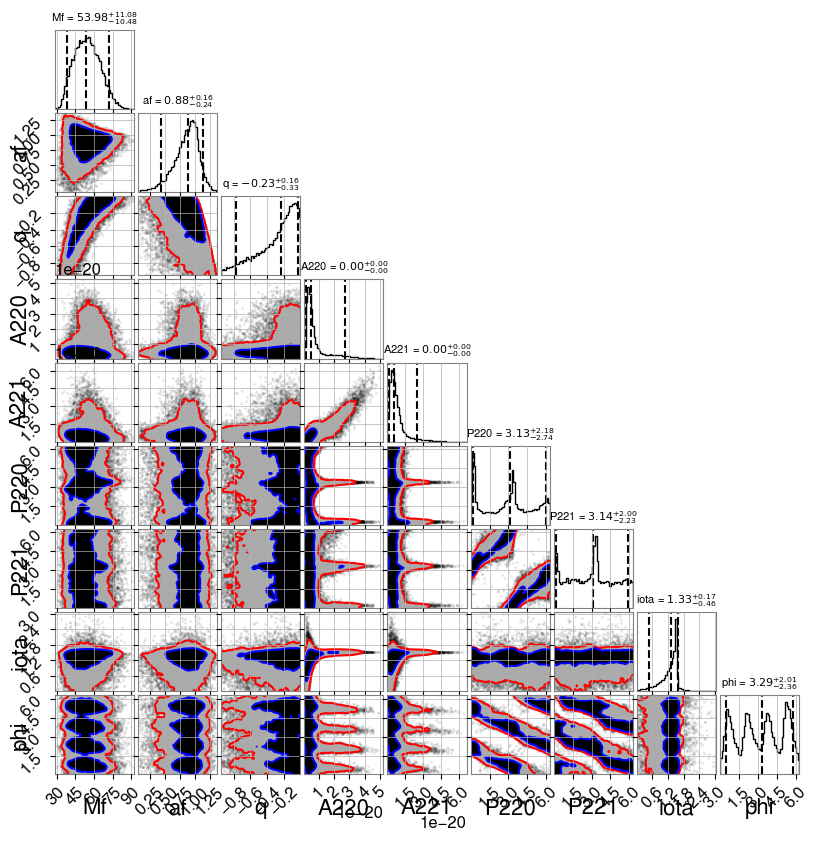

In [12]:
import corner
import numpy as np

plt.rcParams.update({'font.size': 12})
fig = corner.corner(np.vstack([m_170104, c_170104, q_170104, a0_170104, a1_170104, p0_170104, p1_170104, i_170104, phi_170104]).T, labels=['Mf', 'af', 'q', 'A220', 'A221', 'P220', 'P221', 'iota', 'phi'], title_kwargs={"fontsize": 8}, label_kwargs={"fontsize": 16}, quantiles=[0.05, 0.5, 0.95], show_titles=True, smooth = True,  bins=50, plot_contours=True, fill_contours=True, levels=[0.95, 0.67], color="black",
                   hist_kwargs={"linewidth": 1, "histtype": "step"}, contour_kwargs={"colors": ["r", "b"]}, fig_kwargs={"figsize": (30, 25)}, max_n_ticks=6, ticklabel_kwargs= {"fontsize": 4}, labelpad_value = 4)
fig.set_size_inches(8, 8)

# GW 170814 Braneworld Dynamical Prior

In [2]:
# Open the pickle file in binary read mode
import dill
with open('/mnt/pfs/akash.mishra/pytimedomain/job_files/braneworld/dyn_prior/GW170814/ringdown_GW170814_dynprior_updated_new.pkl', 'rb') as file:
    # Load the object from the pickle file
    data_170814 = dill.load(file)

/home/akash.mishra/miniconda3/envs/igwn-py38/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


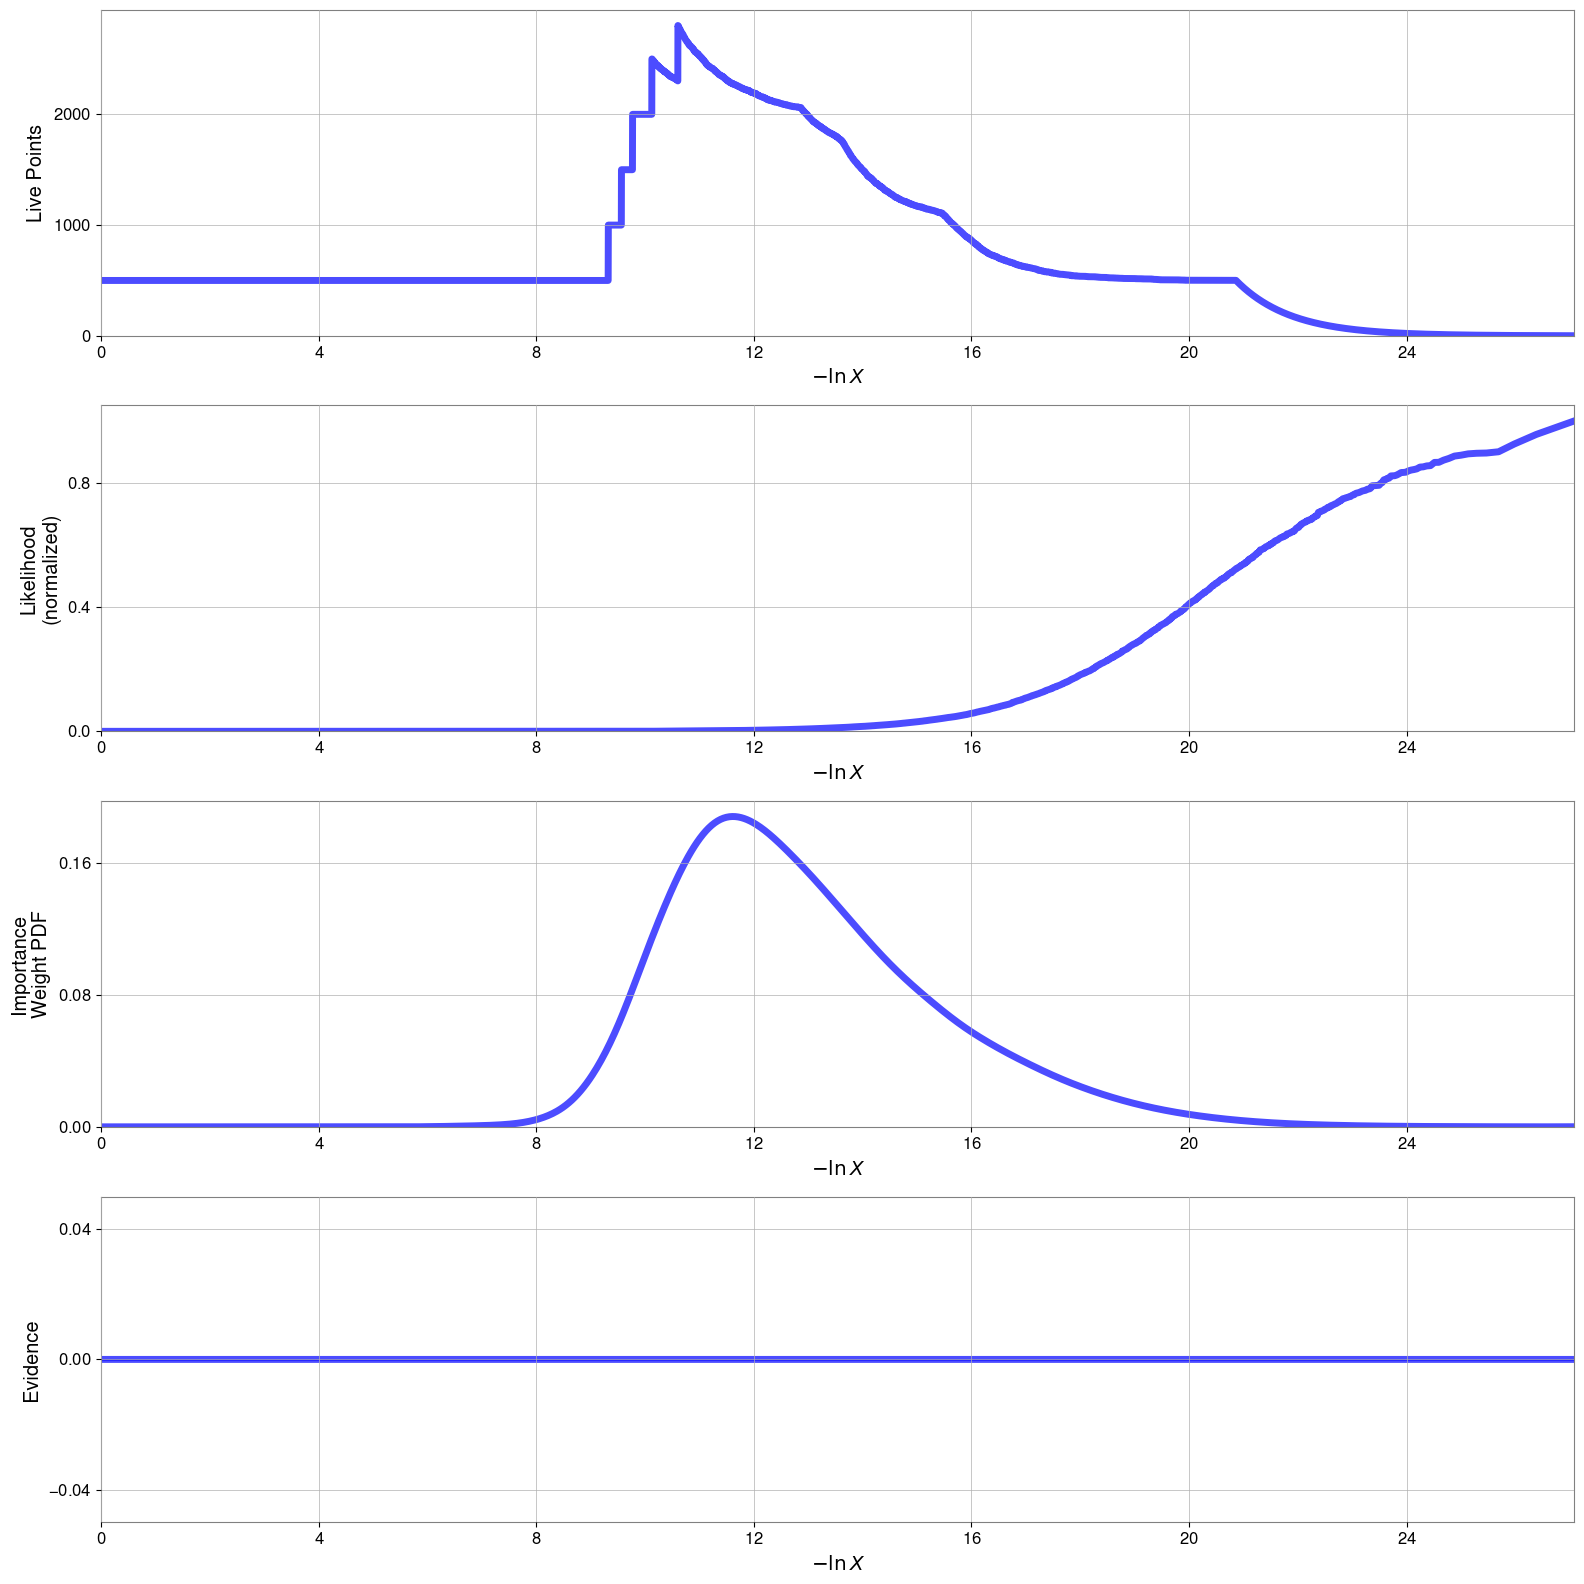

In [3]:
from dynesty import plotting as dyplot

dyplot.runplot(data_170814)
plt.tight_layout()

In [9]:
import numpy as np
mask_170814 = np.where((-data_170814.logvol > 8) & (-data_170814.logvol < 20))
m_170814 = data_170814.samples[:, 0][mask_170814]
c_170814 = data_170814.samples[:, 1][mask_170814]
q_170814 = data_170814.samples[:, 2][mask_170814]

a0_170814 = data_170814.samples[:, 3][mask_170814]
a1_170814 = data_170814.samples[:, 4][mask_170814]

p0_170814 = data_170814.samples[:, 5][mask_170814]
p1_170814 = data_170814.samples[:, 6][mask_170814]

i_170814 = data_170814.samples[:, 7][mask_170814]
psi_170814 = data_170814.samples[:, 8][mask_170814]

Text(0, 0.5, 'q')

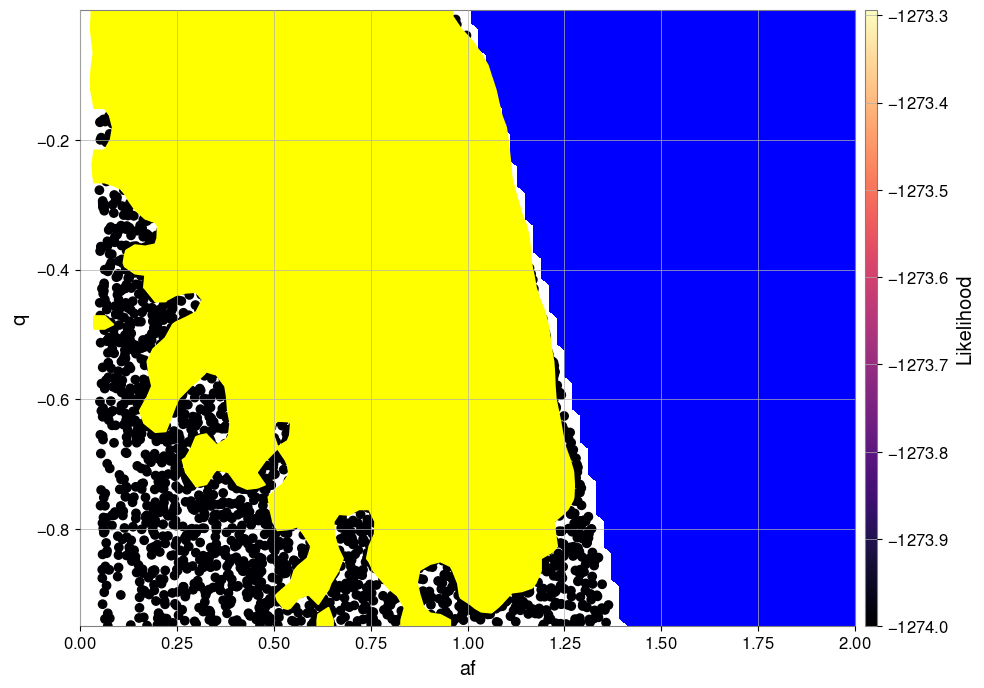

In [7]:
import corner
import matplotlib.pyplot as plt
a_min, a_max = 1e-3, 2
q_min, q_max = -1, 0.0
# Create the mesh grid
num_points = 100  # Adjust the number of points as needed
a_values = np.linspace(a_min, a_max, num_points)
q_values = np.linspace(q_min, q_max, num_points)
a_grid, q_grid = np.meshgrid(a_values, q_values)
mask_1 = 1 - a_grid**2 - q_grid > 0
fig, ax = plt.subplots(figsize=(10, 8))
ax.contourf(a_grid, q_grid, mask_1, levels=[0, 0.2, 1], colors=['blue', 'white'])
# plt.text(1.4, -0.5, 'Extremal Region', fontsize=14, color='white', weight='bold')
#ax.scatter(posterior_a, posterior_s, color='red', label='90% Region')
likelihood = data_170814.logl[mask_170814]

ax.scatter(c_170814, q_170814, c=likelihood, cmap='magma', label='90% Region', vmin = -1274)
ax.colorbar(label='Likelihood')
corner.hist2d(c_170814, q_170814, levels=[0.90], color='yellow', plot_density=False, plot_datapoints=True, smooth=True,
             bins=50, plot_contours=True, fill_contours=True)

plt.xlim([0, 2])

plt.xlabel('af')
plt.ylabel('q')

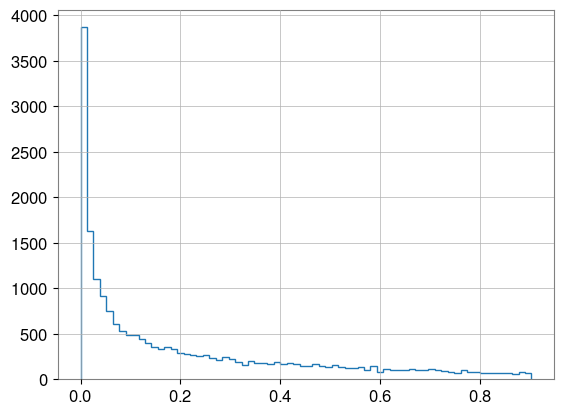

In [19]:
plt.hist((q_170814**2), 70, histtype = 'step');

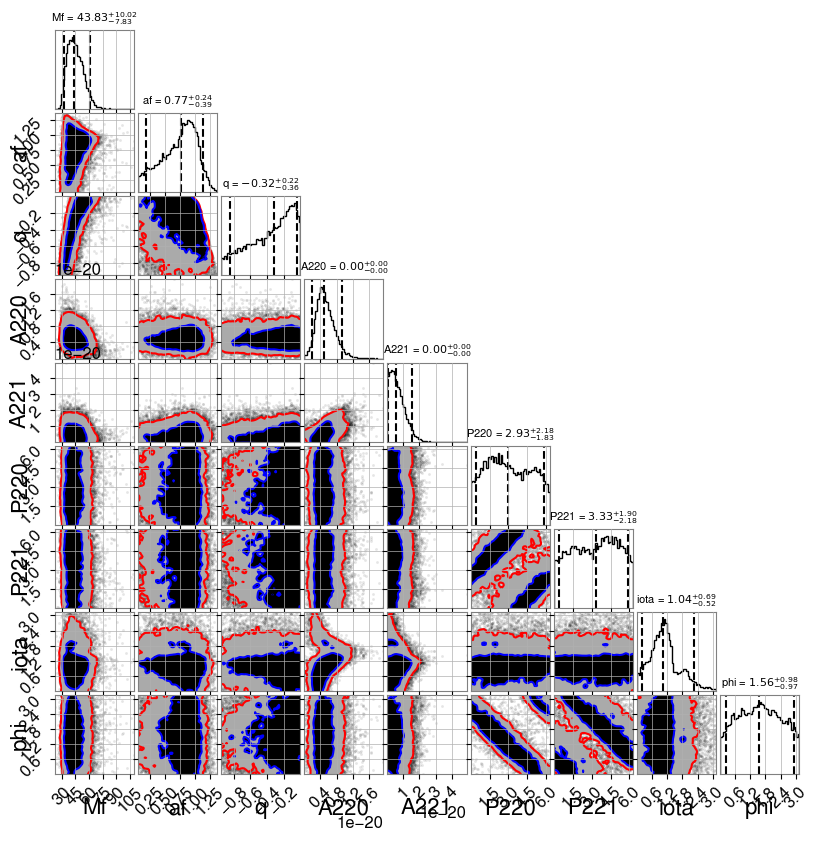

In [10]:
import corner
import numpy as np

plt.rcParams.update({'font.size': 12})
fig = corner.corner(np.vstack([m_170814, c_170814, q_170814, a0_170814, a1_170814, p0_170814, p1_170814, i_170814, psi_170814]).T, labels=['Mf', 'af', 'q', 'A220', 'A221', 'P220', 'P221', 'iota', 'phi'], title_kwargs={"fontsize": 8}, label_kwargs={"fontsize": 16}, quantiles=[0.05, 0.5, 0.95], show_titles=True, smooth = True,  bins=50, plot_contours=True, fill_contours=True, levels=[0.95, 0.67], color="black",
                   hist_kwargs={"linewidth": 1, "histtype": "step"}, contour_kwargs={"colors": ["r", "b"]}, fig_kwargs={"figsize": (30, 25)}, max_n_ticks=6, ticklabel_kwargs= {"fontsize": 4}, labelpad_value = 4)
fig.set_size_inches(8, 8)

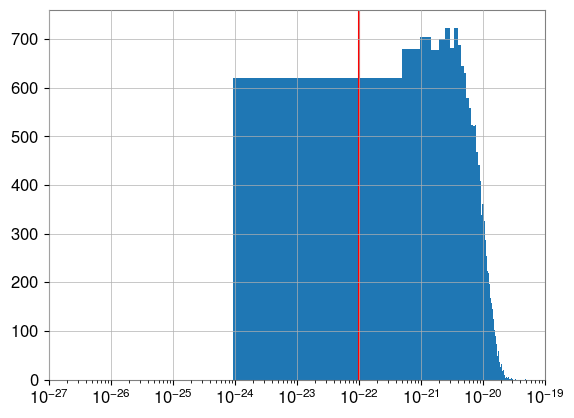

In [31]:
plt.hist(a1_170814, 100);
# plt.axvline(1e-21, color = 'red')
plt.axvline(1e-22, color = 'red')
plt.xlim([1e-27, 1e-19])
plt.xscale('log')

In [29]:
sorted(a1_170814)

[9.522331739628036e-25,
 1.2756565402786465e-24,
 1.742196301563054e-24,
 2.0424321889119344e-24,
 2.1505161924146682e-24,
 2.2500157694959384e-24,
 3.8489806435483184e-24,
 4.881461507503182e-24,
 6.553064865622007e-24,
 7.015964463050677e-24,
 7.477401252210479e-24,
 8.332970921155386e-24,
 1.0106711697016637e-23,
 1.0122037248028586e-23,
 1.0570925944299139e-23,
 1.0727791232750954e-23,
 1.1270408490702093e-23,
 1.138700851542193e-23,
 1.2811585460844627e-23,
 1.3429582096662298e-23,
 1.7036379511319907e-23,
 1.9084238580012708e-23,
 1.9171047668493338e-23,
 1.976628358985733e-23,
 2.0120917257705374e-23,
 2.0371997679525423e-23,
 2.0745816981900068e-23,
 2.2384274012592307e-23,
 2.4437355687089475e-23,
 2.4888561036566343e-23,
 2.6284713461662046e-23,
 2.659464682178326e-23,
 2.7423804115571925e-23,
 2.988105165302064e-23,
 3.0474110836133193e-23,
 3.063155273556204e-23,
 3.1864949559717356e-23,
 3.2825872505091296e-23,
 3.3627718126190074e-23,
 3.636163210037714e-23,
 3.7967696528

# GW 190706 Braneworld Dynamical Prior

In [50]:
# Open the pickle file in binary read mode
import dill
with open('/mnt/pfs/akash.mishra/pytimedomain/job_files/braneworld/dyn_prior/GW190706_222641/ringdown_GW190706_222641_dynprior_updated.pkl', 'rb') as file:
    # Load the object from the pickle file
    data_190706 = dill.load(file)

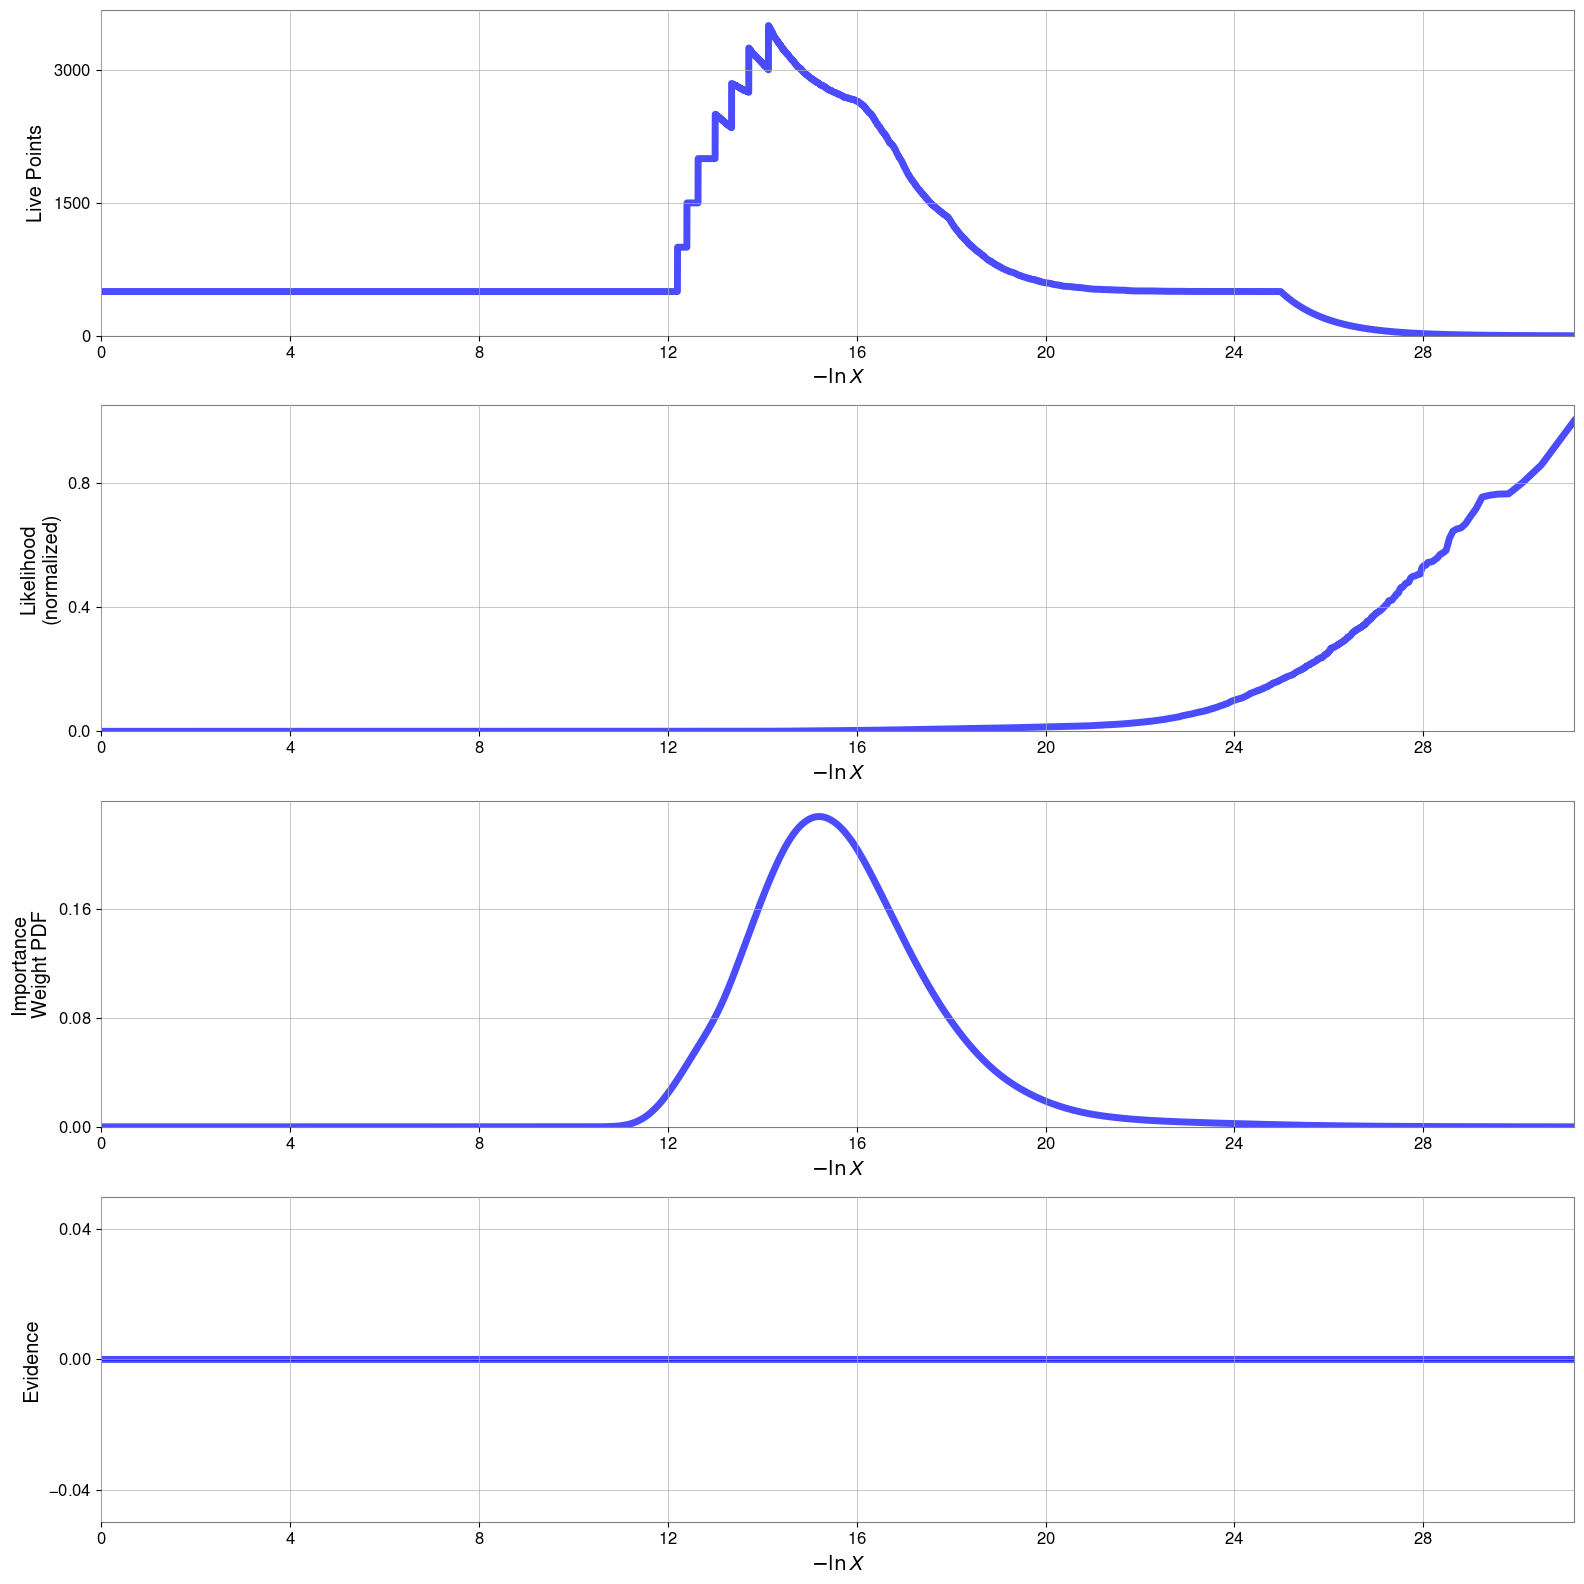

In [51]:
from dynesty import plotting as dyplot

dyplot.runplot(data_190706)
plt.tight_layout()

In [70]:
mask_190706 = np.where((-data_190706.logvol > 17))
m_190706 = data_190706.samples[:, 0][mask_190706]
c_190706 = data_190706.samples[:, 1][mask_190706]
q_190706 = data_190706.samples[:, 2][mask_190706]

a0_190706 = data_190706.samples[:, 3][mask_190706]
a1_190706 = data_190706.samples[:, 4][mask_190706]

p0_190706 = data_190706.samples[:, 5][mask_190706]
p1_190706 = data_190706.samples[:, 6][mask_190706]

i_190706 = data_190706.samples[:, 7][mask_190706]
phi_190706 = data_190706.samples[:, 8][mask_190706]

Text(0, 0.5, 'q')

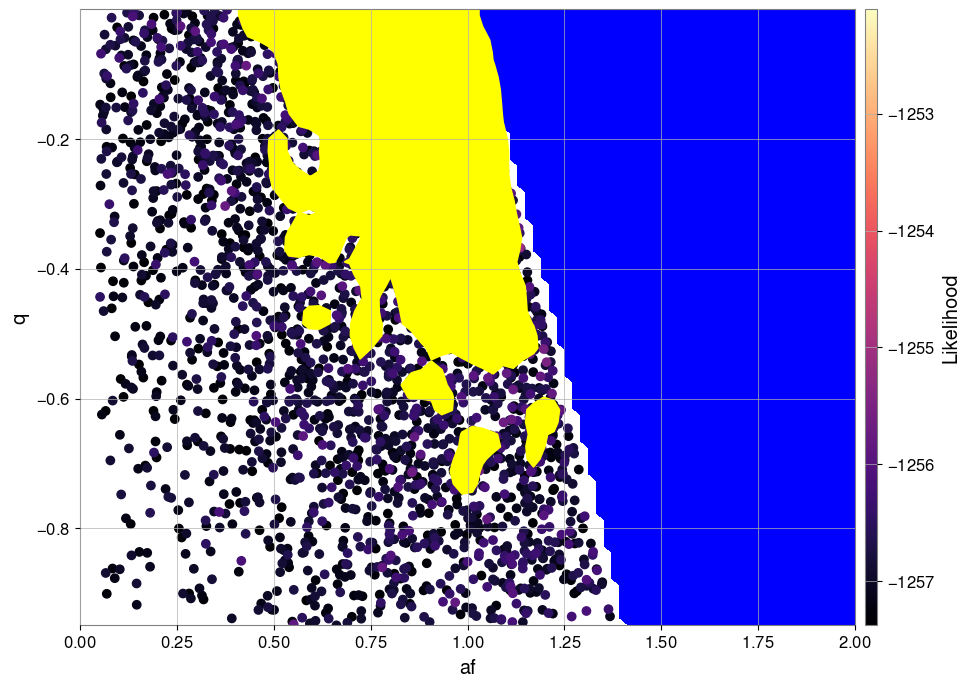

In [71]:
import corner
a_min, a_max = 1e-3, 2
q_min, q_max = -1, 0.0
# Create the mesh grid
num_points = 100  # Adjust the number of points as needed
a_values = np.linspace(a_min, a_max, num_points)
q_values = np.linspace(q_min, q_max, num_points)
a_grid, q_grid = np.meshgrid(a_values, q_values)
mask_1 = 1 - a_grid**2 - q_grid > 0
fig, ax = plt.subplots(figsize=(10, 8))
ax.contourf(a_grid, q_grid, mask_1, levels=[0, 0.2, 1], colors=['blue', 'white'])
# plt.text(1.4, -0.5, 'Extremal Region', fontsize=14, color='white', weight='bold')
#ax.scatter(posterior_a, posterior_s, color='red', label='90% Region')
likelihood = data_190706.logl[mask_190706]

ax.scatter(c_190706, q_190706, c=likelihood, cmap='magma', label='90% Region')
ax.colorbar(label='Likelihood')
corner.hist2d(c_190706, q_190706, levels=[0.70], color='yellow', plot_density=False, plot_datapoints=True, smooth=True,
             bins=50, plot_contours=True, fill_contours=True)

plt.xlim([0, 2])

plt.xlabel('af')
plt.ylabel('q')

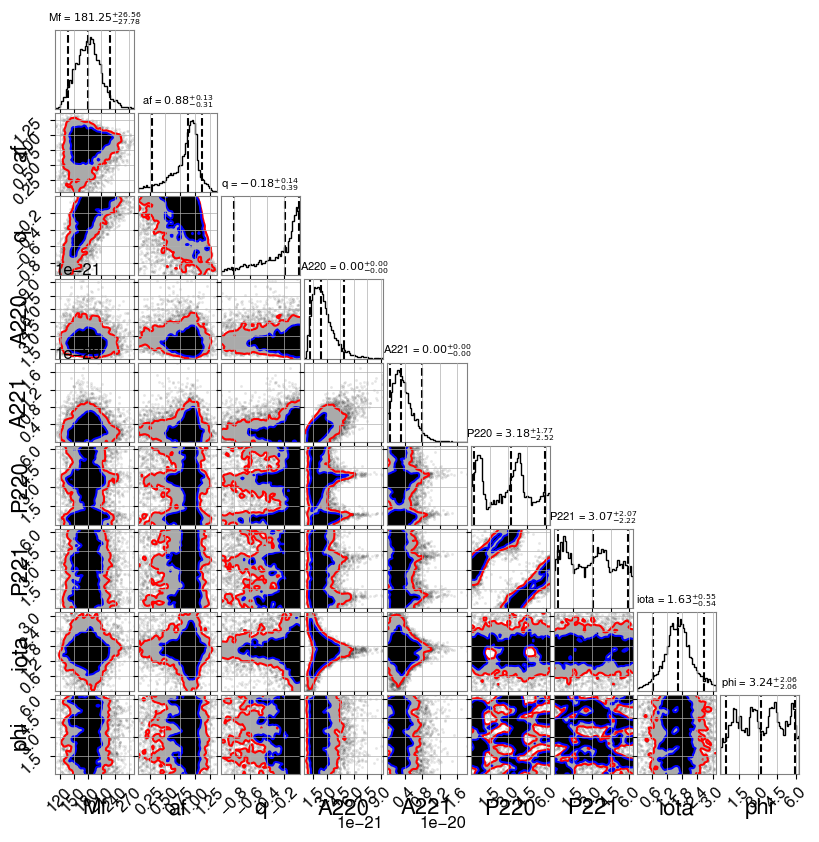

In [73]:
import corner
import numpy as np

plt.rcParams.update({'font.size': 12})
fig = corner.corner(np.vstack([m_190706, c_190706, q_190706, a0_190706, a1_190706, p0_190706, p1_190706, i_190706, phi_190706]).T, labels=['Mf', 'af', 'q', 'A220', 'A221', 'P220', 'P221', 'iota', 'phi'], title_kwargs={"fontsize": 8}, label_kwargs={"fontsize": 16}, quantiles=[0.05, 0.5, 0.95], show_titles=True, smooth = True,  bins=50, plot_contours=True, fill_contours=True, levels=[0.90, 0.67], color="black",
                   hist_kwargs={"linewidth": 1, "histtype": "step"}, contour_kwargs={"colors": ["r", "b"]}, fig_kwargs={"figsize": (30, 25)}, max_n_ticks=6, ticklabel_kwargs= {"fontsize": 4}, labelpad_value = 4)
fig.set_size_inches(8, 8)

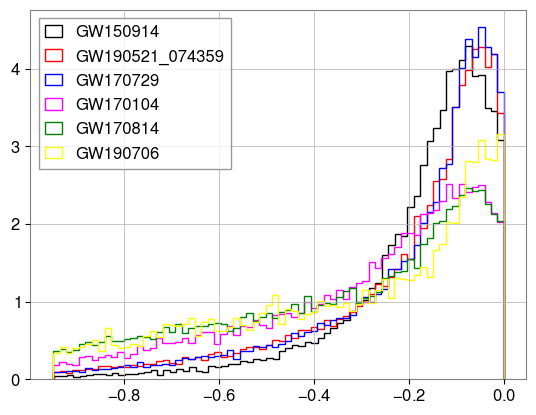

In [60]:
plt.hist(q_150914, 70, histtype = 'step', color = 'black', label = 'GW150914', density = True);
plt.hist(q_190521,70, histtype = 'step', color = 'red', label = 'GW190521_074359', density = True);
plt.hist(q_170729,70, histtype = 'step', color = 'blue', label = 'GW170729', density = True);
plt.hist(q_170104,70, histtype = 'step', color = 'magenta', label = 'GW170104', density = True);
plt.hist(q_170814,70, histtype = 'step', color = 'green', label = 'GW170814', density = True);
plt.hist(q_190706,70, histtype = 'step', color = 'yellow', label = 'GW190706', density = True);
#plt.hist(q_170814,70, histtype = 'step', color = 'green', label = 'GW170814', density = True);
#plt.hist(filtered_Q, 70, histtype = 'step', color = 'cyan', label = 'prior', density = True)
plt.legend(loc='upper left')
#plt.savefig('braneworld.pdf')
plt.show()

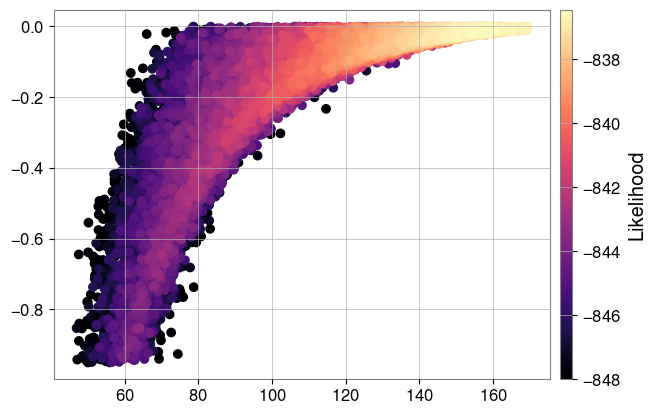

In [178]:
a_min, a_max = 1e-3, 2
q_min, q_max = -1, 0.0

# Create the mesh grid
num_points = 100  # Adjust the number of points as needed
a_values = np.linspace(a_min, a_max, num_points)
q_values = np.linspace(q_min, q_max, num_points)
a_grid, q_grid = np.meshgrid(a_values, q_values)
mask_1 = 1 - a_grid**2 - q_grid > 0
fig, ax = plt.subplots()
#ax.contourf(a_grid, q_grid, mask_1, levels=[0, 0.2, 1], colors=['blue', 'white'])
#ax.scatter(posterior_a, posterior_s, color='red', label='90% Region')
likelihood = data_170729_cp.logl[mask_170729]

ax.scatter(m_170729, q_170729, c=likelihood, cmap='magma', label='90% Region', vmin = -848)
ax.colorbar(label='Likelihood')

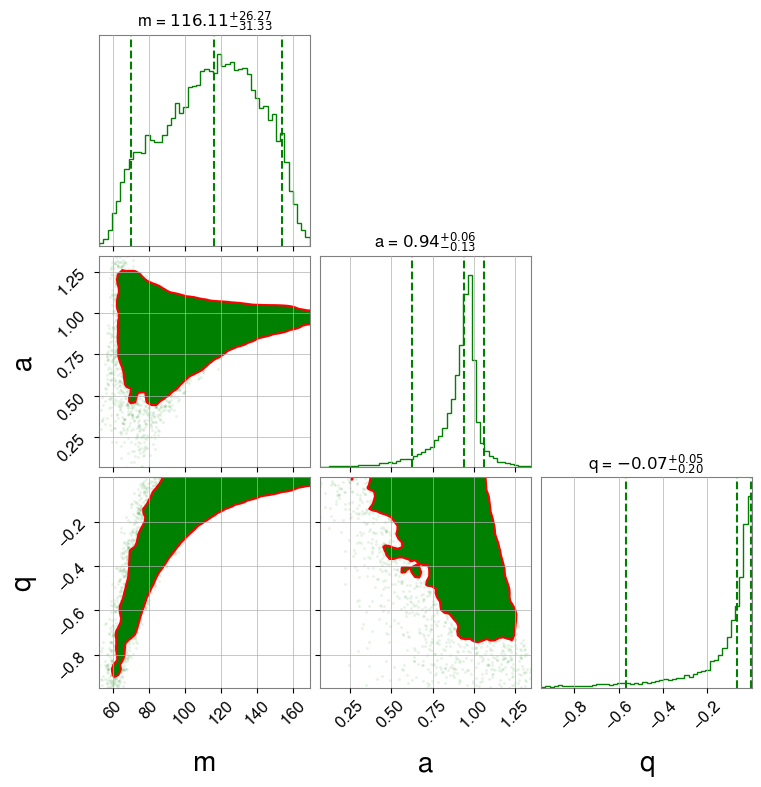

In [160]:
import corner
import numpy as np

plt.rcParams.update({'font.size': 12})
fig = corner.corner(np.vstack([m_170729, c_170729, q_170729]).T, labels=['m', 'a', 'q'], title_kwargs={"fontsize": 12}, label_kwargs={"fontsize": 20}, quantiles=[0.05, 0.5, 0.95], show_titles=True, smooth = True,  bins=50, plot_contours=True, fill_contours=True, levels=[0.95], color="g",
                   hist_kwargs={"linewidth": 1, "histtype": "step"}, contour_kwargs={"colors": ["r", "b"]}, fig_kwargs={"figsize": (20, 16)}, max_n_ticks=6, ticklabel_kwargs= {"fontsize": 10})
fig.set_size_inches(8, 8)

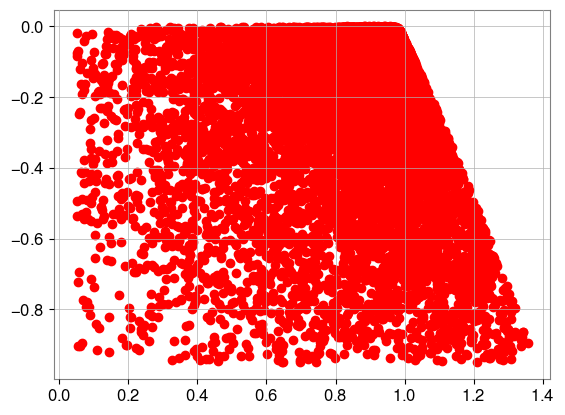

In [230]:
# Assuming you have arrays posterior_a and posterior_s representing scatter plot data
# Assuming you have array samples representing posterior samples for a and s

# Create the scatter plot
plt.scatter(c_170729, q_170729, color='red', label='Scatter Plot')

# Generate the corner plot with 1D histograms and 2D contours
# figure = corner.corner(np.vstack([ c_170729, q_170729]).T, labels=['a', 's'], quantiles=[0.05, 0.95], show_titles=True, title_kwargs={"fontsize": 12})

# Plot the 90% level contour on top of the corner plot
corner.hist2d(c_170729, q_170729, levels=[0.67], plot_contours=True, color='red', smooth=1.0, ax=figure.gca())

plt.show()

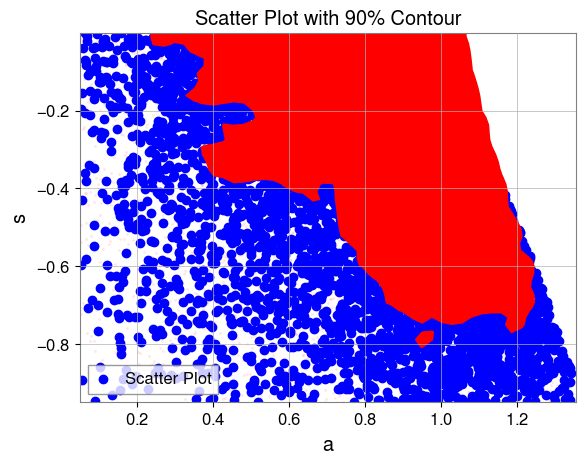

In [253]:
import numpy as np
import matplotlib.pyplot as plt
import corner

# Assuming you have arrays posterior_a and posterior_s representing scatter plot data
# Assuming you have array samples representing posterior samples for a and s

# Create the scatter plot
plt.scatter(posterior_a, posterior_s, color='blue', label='Scatter Plot')

samples = np.vstack([ c_170729, q_170729]).T

# Calculate the 90% percentile values
a_lower, a_upper = np.percentile(samples[:, 0], [5, 95])
s_lower, s_upper = np.percentile(samples[:, 1], [5, 95])

# Plot the 90% level contour
corner.hist2d(c_170729, q_170729, levels=[0.9], color='red', plot_density=False, plot_datapoints=True, smooth=1,
             bins=50, plot_contours=True, fill_contours=True)
# plt.axvline(a_lower, color='black', linestyle='--')
# plt.axvline(a_upper, color='black', linestyle='--')
# plt.axhline(s_lower, color='black', linestyle='--')
# plt.axhline(s_upper, color='black', linestyle='--')

plt.xlabel('a')
plt.ylabel('s')
plt.title('Scatter Plot with 90% Contour')
plt.legend()
plt.show()


(0.0, 2.0)

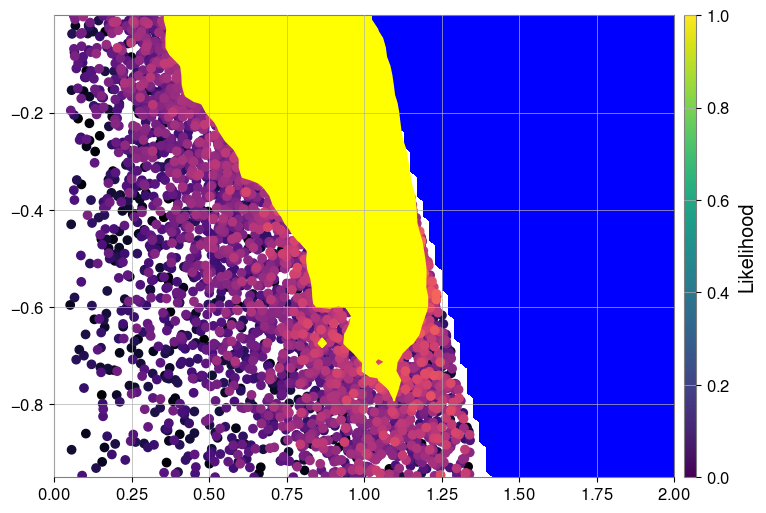

In [284]:
a_min, a_max = 1e-3, 2
q_min, q_max = -1, 0.0
# Create the mesh grid
num_points = 100  # Adjust the number of points as needed
a_values = np.linspace(a_min, a_max, num_points)
q_values = np.linspace(q_min, q_max, num_points)
a_grid, q_grid = np.meshgrid(a_values, q_values)
mask_1 = 1 - a_grid**2 - q_grid > 0
fig, ax = plt.subplots(figsize=(8, 6))
ax.contourf(a_grid, q_grid, mask_1, levels=[0, 0.2, 1], colors=['blue', 'white'])
#ax.scatter(posterior_a, posterior_s, color='red', label='90% Region')
likelihood = data_190521_cp.logl[mask_190521]

ax.scatter(c_190521, q_190521, c=likelihood, cmap='magma', label='90% Region')
corner.hist2d(c_190521, q_190521, levels=[0.85], color='yellow', plot_density=False, plot_datapoints=True, smooth=True,
             bins=50, plot_contours=True, fill_contours=True)
ax.colorbar(label='Likelihood')
plt.xlim([0, 2])

(0.0, 2.0)

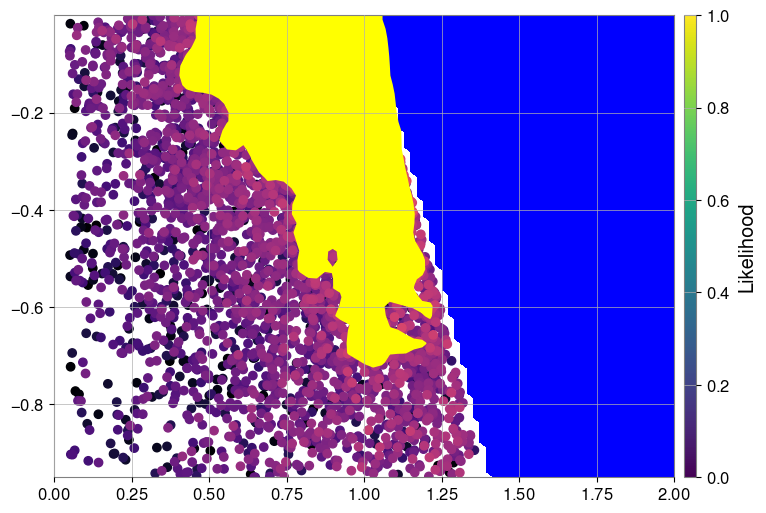

In [289]:
a_min, a_max = 1e-3, 2
q_min, q_max = -1, 0.0
# Create the mesh grid
num_points = 100  # Adjust the number of points as needed
a_values = np.linspace(a_min, a_max, num_points)
q_values = np.linspace(q_min, q_max, num_points)
a_grid, q_grid = np.meshgrid(a_values, q_values)
mask_1 = 1 - a_grid**2 - q_grid > 0
fig, ax = plt.subplots(figsize=(8, 6))
ax.contourf(a_grid, q_grid, mask_1, levels=[0, 0.2, 1], colors=['blue', 'white'])
#ax.scatter(posterior_a, posterior_s, color='red', label='90% Region')
likelihood = data_170729_cp.logl[mask_170729]

ax.scatter(c_170729, q_170729, c=likelihood, cmap='magma', label='90% Region')
corner.hist2d(c_170729, q_170729, levels=[0.85], color='yellow', plot_density=False, plot_datapoints=True, smooth=True,
             bins=50, plot_contours=True, fill_contours=True)
ax.colorbar(label='Likelihood')
plt.xlim([0, 2])


# Load Kerr Results

# GW 190521

In [38]:
with open('/mnt/pfs/akash.mishra/pytimedomain/job_files/GW190521/ringdown_GW190521.pkl', 'rb') as file:
    # Load the object from the pickle file
    data_190521 = dill.load(file)

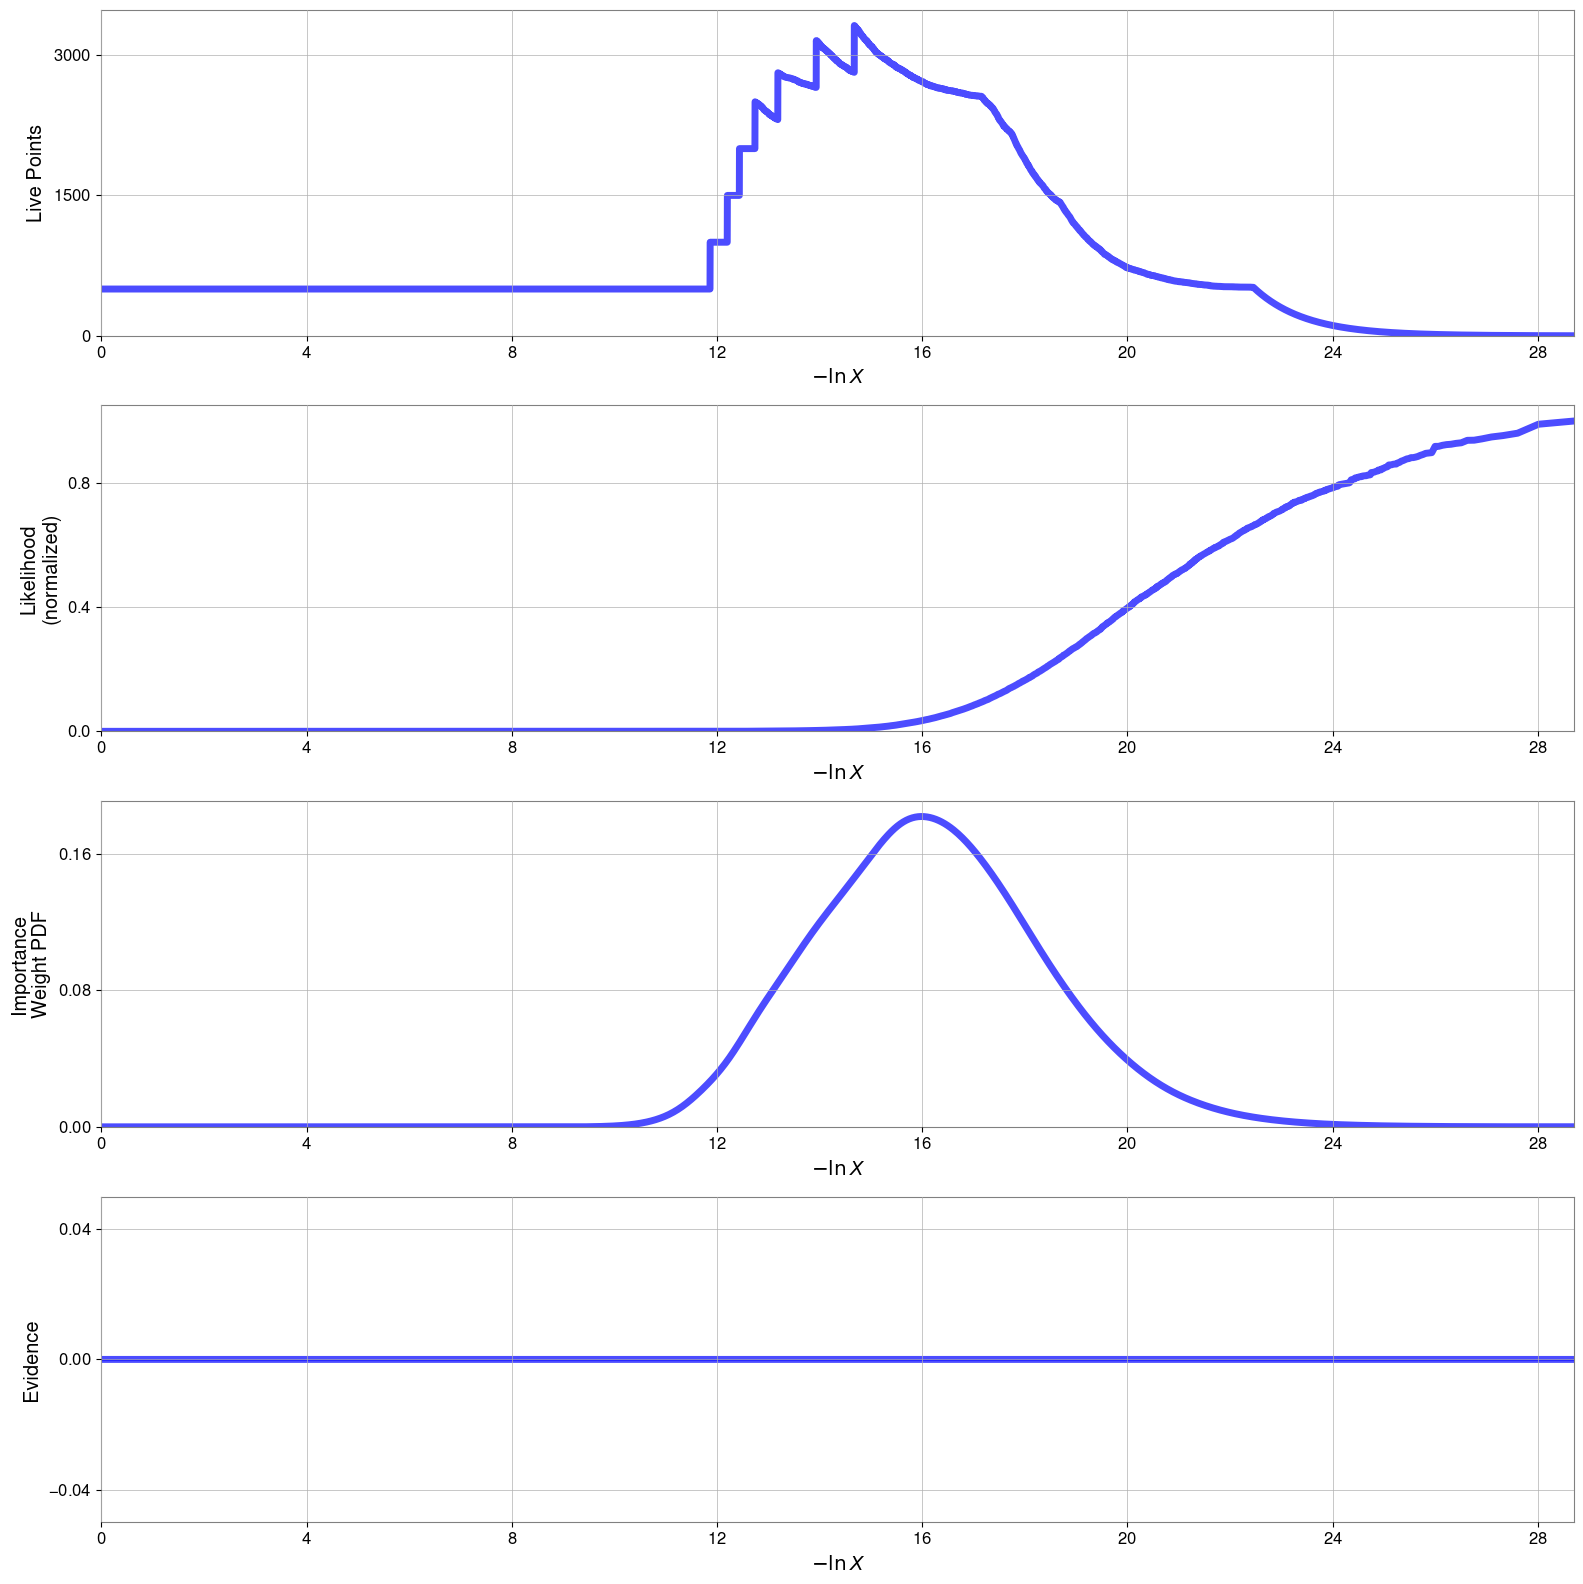

In [39]:
from dynesty import plotting as dyplot

dyplot.runplot(data_190521)
plt.tight_layout()

In [41]:
mask_190521 = np.where((-data_190521.logvol > 12))
m_190521 = data_190521.samples[:, 0][mask_190521]
c_190521 = data_190521.samples[:, 1][mask_190521]


a0_190521 = data_190521.samples[:, 2][mask_190521]
a1_190521 = data_190521.samples[:, 3][mask_190521]

p0_190521 = data_190521.samples[:, 4][mask_190521]
p1_190521 = data_190521.samples[:, 5][mask_190521]

i_190521 = data_190521.samples[:, 6][mask_190521]
phi_190521 = data_190521.samples[:, 7][mask_190521]

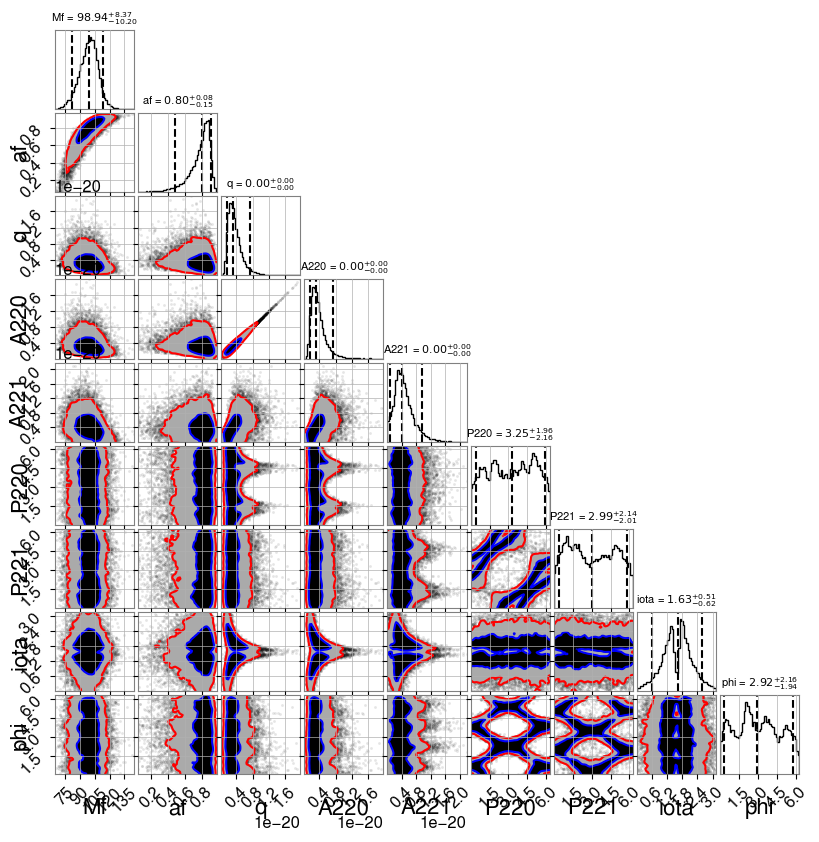

In [45]:
import corner
import numpy as np

plt.rcParams.update({'font.size': 12})
fig = corner.corner(np.vstack([m_190521, c_190521, q_190521, a0_190521, a1_190521, p0_190521, p1_190521, i_190521, phi_190521]).T, labels=['Mf', 'af', 'q', 'A220', 'A221', 'P220', 'P221', 'iota', 'phi'], title_kwargs={"fontsize": 8}, label_kwargs={"fontsize": 16}, quantiles=[0.05, 0.5, 0.95], show_titles=True, smooth = True,  bins=50, plot_contours=True, fill_contours=True, levels=[0.95, 0.67], color="black",
                   hist_kwargs={"linewidth": 1, "histtype": "step"}, contour_kwargs={"colors": ["r", "b"]}, fig_kwargs={"figsize": (30, 25)}, max_n_ticks=6, ticklabel_kwargs= {"fontsize": 4}, labelpad_value = 4)
fig.set_size_inches(8, 8)

# GW 150914

In [64]:
with open('/mnt/pfs/akash.mishra/pytimedomain/job_files/GW150914/ringdown_GW150914.pkl', 'rb') as file:
    # Load the object from the pickle file
    data_150914 = dill.load(file)

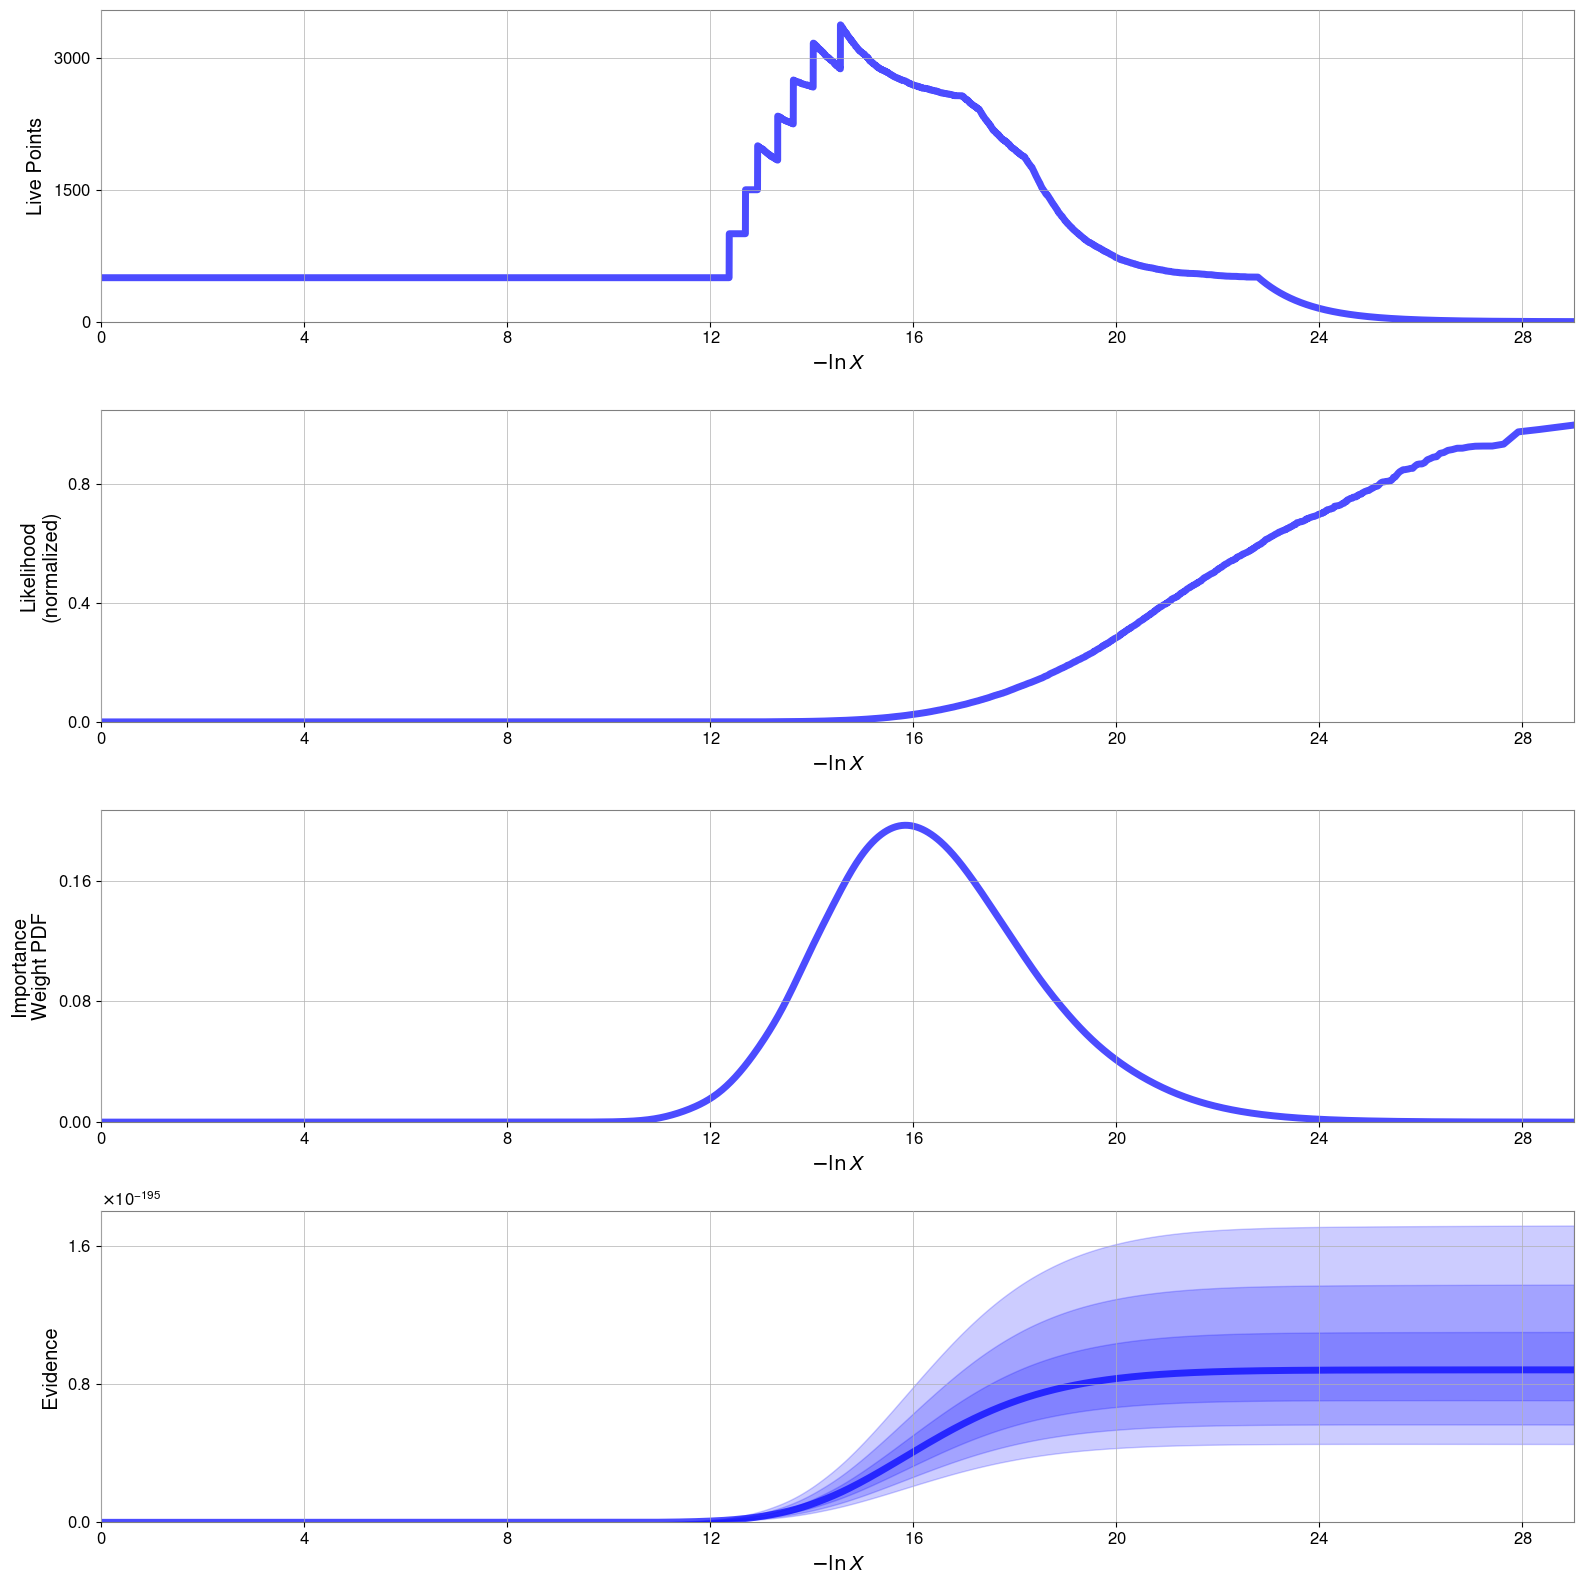

In [65]:
from dynesty import plotting as dyplot

dyplot.runplot(data_150914)
plt.tight_layout()

In [66]:
mask_150914 = np.where((-data_150914.logvol > 12))
m_150914 = data_150914.samples[:, 0][mask_150914]
c_150914 = data_150914.samples[:, 1][mask_150914]


a0_150914 = data_150914.samples[:, 2][mask_150914]
a1_150914 = data_150914.samples[:, 3][mask_150914]

p0_150914 = data_150914.samples[:, 4][mask_150914]
p1_150914 = data_150914.samples[:, 5][mask_150914]

i_150914 = data_150914.samples[:, 6][mask_150914]
phi_150914 = data_150914.samples[:, 7][mask_150914]

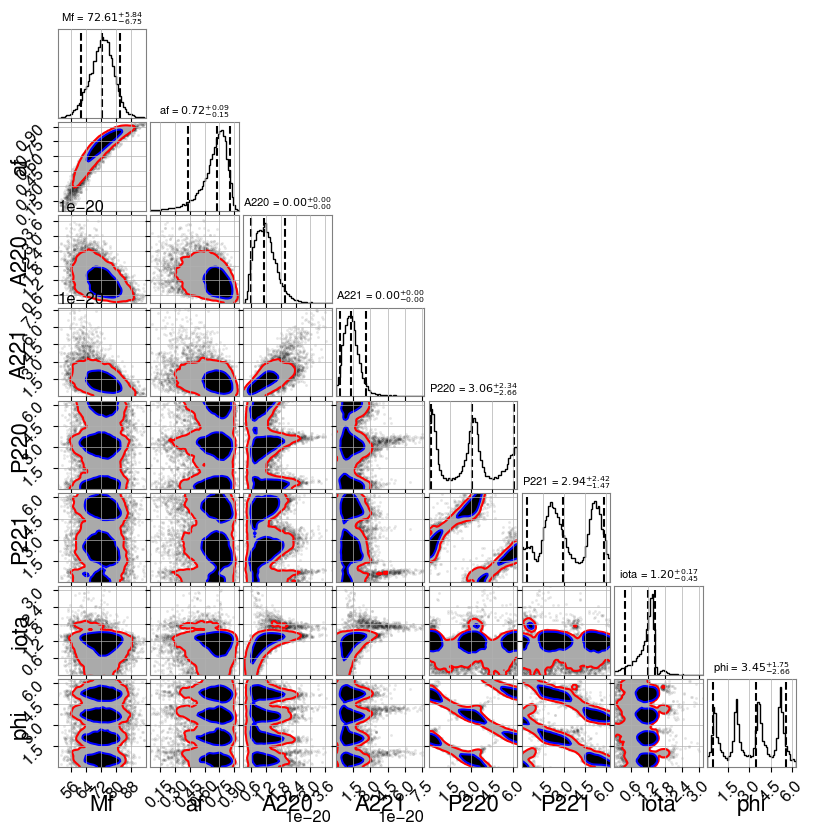

In [68]:
import corner
import numpy as np

plt.rcParams.update({'font.size': 12})
fig = corner.corner(np.vstack([m_150914, c_150914, a0_150914, a1_150914, p0_150914, p1_150914, i_150914, phi_150914]).T, labels=['Mf', 'af', 'A220', 'A221', 'P220', 'P221', 'iota', 'phi'], title_kwargs={"fontsize": 8}, label_kwargs={"fontsize": 16}, quantiles=[0.05, 0.5, 0.95], show_titles=True, smooth = True,  bins=50, plot_contours=True, fill_contours=True, levels=[0.95, 0.67], color="black",
                   hist_kwargs={"linewidth": 1, "histtype": "step"}, contour_kwargs={"colors": ["r", "b"]}, fig_kwargs={"figsize": (30, 25)}, max_n_ticks=6, ticklabel_kwargs= {"fontsize": 4}, labelpad_value = 4)
fig.set_size_inches(8, 8)
plt.savefig('/mnt/pfs/akash.mishra/pytimedomain/job_files/GW150914/GW150914_corner_kerr.pdf')

(array([ 753., 1421., 2725., 6270., 6863.,  483.,  141.,   26.,
          10.,    7.]),
 array([2.09149889e-03, 3.15526263e-01, 6.28961026e-01,
        9.42395790e-01, 1.25583055e+00, 1.56926532e+00,
        1.88270008e+00, 2.19613484e+00, 2.50956961e+00,
        2.82300437e+00, 3.13643914e+00]),
 <BarContainer object of 10 artists>)

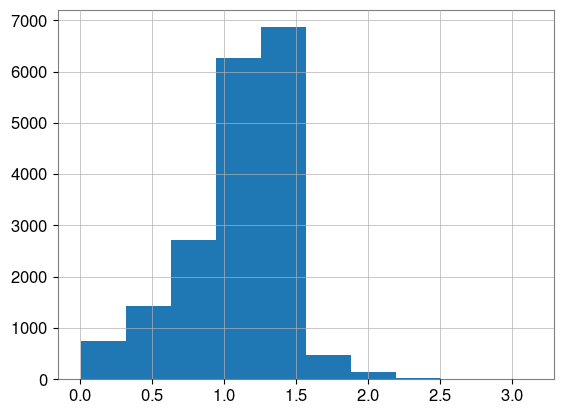

In [51]:
plt.hist(i_150914)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
#import sympy as sp
from sympy import *
#from sympy.mpmath import *
from scipy import optimize
#from __future__ import division
#from sympy.physics.units import *
from math import *

from mpmath import *
#from __future__ import division, print_function, absolute_import
import mpmath as mp
mp.pretty = True
import time

In [2]:
"""In this notebook we compute the quasinormal modes of Schwarzschild black hole using the continued fraction method.
This will work for any system for which the three term recurrence relations are known. 

Reference: Leaver Proc. R. Soc. Lond. A 402, 285-298 (1985)"""

def qnm_solver_kerr_tidal(a, q, l,  m, s, N, n_inv):
    k1 = 0.5*np.abs(m - s)
    k2 = 0.5*np.abs(m + s)
    Alm = l*(l + 1) - s*(s + 1)
    
    """The choice of initial qnm value is very important. A bad choice may not give good convergence. The following 
    choice works for all range of spin a."""
    
    #winit = 2*(0.37 - 0.08*1j)
    
    
    Alist = 1j*np.zeros(7)
    witer = 1j*np.zeros(7)
    
 
    
    ie = 0;


    while ie<7:
        
    
    
        
        K = (1 - 4*a*a -4*q)
        Kr = np.sqrt(K)
        
    
        def alpha(n, w):
            return -1 + 4*(a**2) - 2*n + 8*(a**2)*n - (n**2) + 4*(a**2)*(n**2) + s - 4*(a**2)*s + n*s - 4*(a**2)*n*s + 1j*w - 4j*(a**2)*w + 1j*n*w - 4j*(a**2)*n*w - 2j*a*m*Kr - 2j*a*n*m*Kr + 1j*w*Kr + 1j*n*w*Kr + 4*q + 8*n*q + 4*(n**2)*q - 4*s*q - 4*n*s*q - 4j*w*q - 4j*n*w*q - 2j*w*q*Kr - 2j*n*w*q*Kr
        
        def beta(n, w):
            return 1 - 4*(a**2) + Alm - 4*(a**2)*Alm + 2*n - 8*(a**2)*n + 2*(n**2) -8*(a**2)*(n**2) + s - 4*(a**2)*s - 2j*w + 8j*(a**2)*w + 2*a*m*w - 8*(a**3)*m*w - 4j*n*w + 16j*(a**2)*n*w - 4*(w**2) + 17*(a**2)*(w**2) - 4*(a**4)*(w**2) + 2j*a*m*Kr + 4j*a*n*m*Kr - 2j*w*Kr + 4j*(a**2)*w*Kr + 4*a*m*w*Kr - 4j*n*w*Kr + 8j*(a**2)*n*w*Kr - 4*(w**2)*Kr + 8*(a**2)*(w**2)*Kr - 4*q - 4*Alm*q - 8*n*q - 8*(n**2)*q - 4*s*q + 8j*w*q - 8*a*m*w*q +16j*n*w*q + 20*(w**2)*q - 20*(a**2)*(w**2)*q + 6j*w*q*Kr + 12j*n*w*Kr*q + 12*(w**2)*q*Kr - 16*(w**2)*(q**2)                                                                                                                                                                             
       
        def gamma(n, w):
            return -(n**2) + 4*(a**2)*(n**2) - n*s + 4*(a**2)*n*s + 3j*n*w - 12j*(a**2)*n*w + 2j*s*w - 8j*(a**2)*s*w + 2*(w**2) - 8*(a**2)*(w**2) - 2j*a*n*m*Kr - 4*a*m*w*Kr + 1j*n*w*Kr + 2*(w**2)*Kr + 4*(n**2)*q + 4*n*s*q - 12j*n*w*q - 8j*s*w*q - 8*(w**2)*q - 2j*n*w*q*Kr - 4*(w**2)*q*Kr
            
            
        def Leaver31(w):
                
            Rn = -1. # Is this sign correct?
            
            for i in range(N, n_inv, -1): # n_inv is not included
                Rn = gamma(i, w) / (beta(i, w) - alpha(i, w) * Rn)
                
            return Rn
        
        def Leaver33(w):
            return (beta(n_inv, w)/alpha(n_inv, w)) - Leaver31(w)
        
        
        wang = findroot(Leaver33, winit) 
        
        witer[ie] = wang;
        
        
        def alpha_ang(n, Sep):
            return -2*(n+1)*(n + 2*k1 + 1)
        
        def beta_ang(n, Sep):
            return k1 + k1**2 + k2 + 2*k1*k2 + k2**2 + n + 2*k1*n + 2*k2*n + n**2 - s - s**2 - Sep - 2*a*wang - 4*a*k1*wang - 4*a*n*wang - 2*a*s*wang - (a**2)*(wang**2)
        
        def gamma_ang(n, Sep):
            return 2*a*wang*(n + k1 + k2 + s)
            
            
        
        
        def Leaver31_ang(Sep):
            Rn_ang = -1.0 # Is this sign correct?
            
            
            for i in range(N, n_inv, -1): # n_inv is not included
                Rn_ang = gamma_ang(i, Sep) / (beta_ang(i, Sep) - alpha_ang(i, Sep) * Rn_ang)
           
                
            return Rn_ang
        
        def Leaver33_ang(Sep):
            
            return (beta_ang(n_inv, Sep)/alpha_ang(n_inv, Sep)) - Leaver31_ang(Sep)
        
        
        Alm = findroot(Leaver33_ang, Alm)
        
        Alist[ie] = Alm
        
                
        ie += 1;
        
     
    return  witer[-1]

In [3]:
import pandas as pd
data220 = pd.read_pickle(r'/mnt/pfs/akash.mishra/pytimedomain/qnm_data_220_updated_new.pickle')

In [4]:
data220.keys()

dict_keys([0.0, -0.005, -0.01, -0.015, -0.02, -0.025, -0.03, -0.035, -0.04, -0.045, -0.05, -0.055, -0.06, -0.065, -0.07, -0.075, -0.08, -0.085, -0.09, -0.095, -0.1, -0.105, -0.11, -0.115, -0.12, -0.125, -0.13, -0.135, -0.14, -0.145, -0.15, -0.155, -0.16, -0.165, -0.17, -0.17500000000000002, -0.18, -0.185, -0.19, -0.195, -0.2, -0.20500000000000002, -0.21, -0.215, -0.22, -0.225, -0.23, -0.23500000000000001, -0.24, -0.245, -0.25, -0.255, -0.26, -0.27, -0.265, -0.275, -0.28, -0.28500000000000003, -0.29, -0.295, -0.3, -0.305, -0.31, -0.315, -0.32, -0.325, -0.33, -0.335, -0.34, -0.34500000000000003, -0.35000000000000003, -0.355, -0.36, -0.365, -0.37, -0.375, -0.38, -0.385, -0.39, -0.395, -0.4, -0.405, -0.41000000000000003, -0.41500000000000004, -0.42, -0.425, -0.43, -0.435, -0.44, -0.445, -0.45, -0.455, -0.46, -0.465, -0.47000000000000003, -0.47500000000000003, -0.48, -0.485, -0.49, -0.495, -0.5, -0.505, -0.51, -0.515, -0.52, -0.525, -0.53, -0.535, -0.54, -0.545, -0.55, -0.555, -0.56, -0.565

In [5]:
qnm_data_220 = pd.read_pickle('/mnt/pfs/akash.mishra/pytimedomain/data_files/braneworld_qnm_files/qnm_data_220_updated.pickle')
q_list = list(qnm_data_220.keys())
a_list = list(qnm_data_220[0.0].keys())

In [6]:
def am(x):
    return (2*np.sqrt(1-x))/(np.sqrt(1-4*x))

def amm(x):
    return 1/am(x)

In [60]:
import time 
st = time.time()
q_ind = 193

qnm_a = {}
a1m = np.arange(0.02, np.sqrt(1-(q_list[q_ind])), 0.005)
a_comp = a1m*amm(q_list[q_ind])
for k in range(len(a_comp)):
    winit = 2*(0.31 - 0.08*1j)
    val = float(mp.nstr(qnm_solver_kerr_tidal(a_comp[k], q_list[q_ind], 2, 2, -2, 10, 0).real)) + 1j*float(mp.nstr(qnm_solver_kerr_tidal(a_comp[k], q_list[q_ind], 2, 2, -2, 10, 0).imag))
    qnm_a[a1m[k]] = val
    winit = val
#data220[q_list[q_ind]] = qnm_a

en = time.time()
print(en - st)

526.2516760826111


In [65]:
qnm_a

{0.02: (0.4913274881021561-0.1337488672691352j),
 0.025: (0.49197588772970163-0.13370832237627706j),
 0.030000000000000002: (0.49262700428525374-0.13366746534131094j),
 0.035: (0.49328085767311647-0.13362629403835957j),
 0.04000000000000001: (0.4939374680156026-0.13358480632321426j),
 0.045000000000000005: (0.4945968556562429-0.13354300003305905j),
 0.05: (0.4952590411630531-0.1335008729861922j),
 0.05500000000000001: (0.4959240453318605-0.13345842298174415j),
 0.06000000000000001: (0.4965918891896917-0.13341564779939238j),
 0.06500000000000002: (0.49726259399822176-0.13337254519907288j),
 0.07: (0.49793618125728767-0.13332911292068775j),
 0.07500000000000001: (0.4986126727084668-0.1332853486838097j),
 0.08000000000000002: (0.4992920903387217-0.13324125018738248j),
 0.08500000000000002: (0.49997445638411286-0.13319681510941733j),
 0.09000000000000001: (0.500659793333582-0.13315204110668594j),
 0.09500000000000001: (0.5013481239328055-0.13310692581440878j),
 0.10000000000000002: (0.5020

In [55]:
np.array(list(qnm_a.keys()))[252]

1.2800000000000002

In [64]:
for k in range(270, len(a_comp)):
    winit =1.1582412465941962-0.07560391088491683j
    val = float(mp.nstr(qnm_solver_kerr_tidal(a_comp[k], q_list[q_ind], 2, 2, -2, 10, 0).real)) + 1j*float(mp.nstr(qnm_solver_kerr_tidal(a_comp[k], q_list[q_ind], 2, 2, -2, 10, 0).imag))
    qnm_a[a1m[k]] = val

1.1350000000000002